In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pylab
import math
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from pyod.models.knn import KNN
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

%matplotlib inline

In [2]:
df=pd.read_excel('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Квартиры Киров/Квартиры_Киров_выбока_2.xlsx', sheet_name = 0)
df.head()

,Комнатность,LN(Общая площадь),Общая площадь,Площадь кухни,Жилая площадь,Этаж 1,Этаж 2,Этажей в доме,Ремонт,Материал стен,...,последний,средний,деревянный,кирпичный,монолитный,панельный,дизайнерский,евро,косметический,требует ремонта
0,2к,3.799974,44.7,5.900000,29.458690,5,последний,5,евро,панельный,...,1,0,0,0,0,1,0,1,0,0
1,1к,3.465736,32.0,6.900000,17.655975,2,средний,5,косметический,кирпичный,...,0,1,0,1,0,0,0,0,1,0
2,студия,3.502550,33.2,6.633333,18.193506,3,последний,3,евро,кирпичный,...,1,0,0,1,0,0,0,1,0,0
3,2к,3.943522,51.6,8.800000,28.744021,6,средний,7,евро,кирпичный,...,0,1,0,1,0,0,0,1,0,0
4,3к,3.998201,54.5,18.000000,27.597229,18,средний,19,дизайнерский,панельный,...,0,1,0,0,0,1,1,0,0,0


1. Выборка 1 - без исключения выбросов (с учетом нормализации и стандартизации).
2. Выборка 2 - исключение экстремальных выбросов.
3. Выборка 3 - исключение выбросов по общей площади и цене.
4. Выборка 4 - исключение выбросов по логарифмированным общей площади и цене.
5. Выборка 5 - исключение выбросов алгоритмом KNN.

<font size = 3><div style="text-align: justify">**Выборка 1:**</div></font>

In [3]:
df_v1 = df.copy()
len(df_v1)

2399

In [35]:
#X = df_v1[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v1[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v1['Цена']
Y = df_v1['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [59]:
catb = CatBoostRegressor(iterations=2500, #максимальное количество построенных деревьев
                         random_seed=5, 
                         learning_rate=0.008, #скорость обучения, определяет насколько быстро или медленно модель будет учиться
                         max_depth=4, #глубина дерева
                         #l2_leaf_reg=0.01, #коэффициент при члене регуляризации L2 функции потерь
                         bagging_temperature=1,
                         random_strength=1,
                         #one_hot_max_size=8, #не используем one hot encoding, а включаем one_hot_max_size
                         loss_function='MAE',
                         od_type='Iter', #если модель переобучилась
                         od_wait=20) #делай остановку через 20 итераций
#если хотим хорошее качество, то уменьшаем learning_rate и увеличиваем iterations.
#если модель слишком рано переобучается, то l2_leaf_reg увеличиваем.

#cat_features = list(range(0, X.shape[1]))
#cat_features = list(df['transmission'])
#print(cat_features) 

catb.fit(X_train, Y_train, 
         #cat_features=cat_features, #массив с индексами категориальных фичей
         eval_set=(X_test, Y_test),
         verbose=False, 
         plot=True) #включение графика

Ypred = catb.predict(X_test)

pred_train = catb.predict(X_train)
mse_train = mse(Y_train, pred_train)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
#print(f'MSE на обучении {mse_train:.2f}')
print("MAE на обучении:", round(mae(Y_train, pred_train), 4))

pred_test = catb.predict(X_test)
mse_test = mse(Y_test, pred_test)

print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')
#print(f'MSE на тесте {mse_test:.2f}')
print("MAE на тесте:", round(mae(Y_test, pred_test), 4))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train R2 0.932
MAE на обучении: 0.0944
Test R2 0.920
MAE на тесте: 0.1102


In [60]:
params = catb.get_params()
params

{'iterations': 2500,
 'learning_rate': 0.008,
 'loss_function': 'MAE',
 'od_wait': 20,
 'od_type': 'Iter',
 'random_seed': 5,
 'random_strength': 1,
 'bagging_temperature': 1,
 'max_depth': 4}

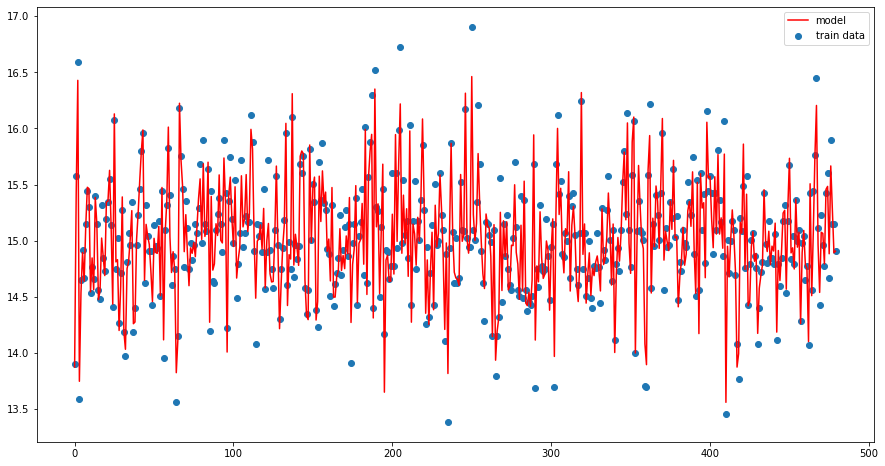

In [61]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(Y_test)), Ypred, c='r', label='model');
plt.scatter(range(len(Y_test)), Y_test, label='train data')
plt.legend();

In [62]:
cv_score = cross_val_score(catb, X_train, Y_train, cv = 5)
print("CV mean score:", cv_score.mean())
#90,59%

0:	learn: 0.4003867	total: 1.03ms	remaining: 2.58s
1:	learn: 0.3981994	total: 2.02ms	remaining: 2.52s
2:	learn: 0.3962299	total: 2.96ms	remaining: 2.46s
3:	learn: 0.3941513	total: 3.86ms	remaining: 2.41s
4:	learn: 0.3923229	total: 5.03ms	remaining: 2.51s
5:	learn: 0.3904127	total: 6.8ms	remaining: 2.83s
6:	learn: 0.3884172	total: 8.28ms	remaining: 2.95s
7:	learn: 0.3865192	total: 9.31ms	remaining: 2.9s
8:	learn: 0.3845486	total: 10.2ms	remaining: 2.83s
9:	learn: 0.3825703	total: 11.1ms	remaining: 2.76s
10:	learn: 0.3808774	total: 12ms	remaining: 2.72s
11:	learn: 0.3789255	total: 12.9ms	remaining: 2.68s
12:	learn: 0.3769658	total: 13.8ms	remaining: 2.64s
13:	learn: 0.3750687	total: 14.7ms	remaining: 2.61s
14:	learn: 0.3732569	total: 15.6ms	remaining: 2.58s
15:	learn: 0.3713249	total: 16.4ms	remaining: 2.55s
16:	learn: 0.3696257	total: 17.3ms	remaining: 2.52s
17:	learn: 0.3679462	total: 18.1ms	remaining: 2.5s
18:	learn: 0.3662823	total: 19.1ms	remaining: 2.49s
19:	learn: 0.3646277	total:

171:	learn: 0.2192025	total: 155ms	remaining: 2.1s
172:	learn: 0.2186195	total: 156ms	remaining: 2.1s
173:	learn: 0.2181208	total: 157ms	remaining: 2.1s
174:	learn: 0.2176356	total: 158ms	remaining: 2.1s
175:	learn: 0.2171160	total: 159ms	remaining: 2.1s
176:	learn: 0.2165095	total: 160ms	remaining: 2.1s
177:	learn: 0.2159865	total: 161ms	remaining: 2.1s
178:	learn: 0.2153670	total: 162ms	remaining: 2.1s
179:	learn: 0.2149528	total: 163ms	remaining: 2.1s
180:	learn: 0.2143243	total: 164ms	remaining: 2.1s
181:	learn: 0.2138038	total: 166ms	remaining: 2.11s
182:	learn: 0.2132614	total: 167ms	remaining: 2.11s
183:	learn: 0.2128571	total: 169ms	remaining: 2.12s
184:	learn: 0.2123116	total: 170ms	remaining: 2.12s
185:	learn: 0.2117762	total: 171ms	remaining: 2.12s
186:	learn: 0.2112682	total: 171ms	remaining: 2.12s
187:	learn: 0.2107708	total: 172ms	remaining: 2.12s
188:	learn: 0.2103226	total: 173ms	remaining: 2.12s
189:	learn: 0.2098309	total: 174ms	remaining: 2.12s
190:	learn: 0.2094297	

352:	learn: 0.1606754	total: 320ms	remaining: 1.95s
353:	learn: 0.1603819	total: 321ms	remaining: 1.95s
354:	learn: 0.1602275	total: 322ms	remaining: 1.95s
355:	learn: 0.1600792	total: 323ms	remaining: 1.94s
356:	learn: 0.1599099	total: 324ms	remaining: 1.94s
357:	learn: 0.1597567	total: 325ms	remaining: 1.94s
358:	learn: 0.1595386	total: 326ms	remaining: 1.94s
359:	learn: 0.1593453	total: 327ms	remaining: 1.94s
360:	learn: 0.1591280	total: 327ms	remaining: 1.94s
361:	learn: 0.1589442	total: 329ms	remaining: 1.94s
362:	learn: 0.1587281	total: 330ms	remaining: 1.94s
363:	learn: 0.1585769	total: 331ms	remaining: 1.94s
364:	learn: 0.1584262	total: 332ms	remaining: 1.94s
365:	learn: 0.1581688	total: 333ms	remaining: 1.94s
366:	learn: 0.1580212	total: 334ms	remaining: 1.94s
367:	learn: 0.1577511	total: 335ms	remaining: 1.94s
368:	learn: 0.1576225	total: 336ms	remaining: 1.94s
369:	learn: 0.1574173	total: 337ms	remaining: 1.94s
370:	learn: 0.1572067	total: 338ms	remaining: 1.94s
371:	learn: 

541:	learn: 0.1362309	total: 487ms	remaining: 1.76s
542:	learn: 0.1361509	total: 488ms	remaining: 1.76s
543:	learn: 0.1360240	total: 489ms	remaining: 1.76s
544:	learn: 0.1359673	total: 490ms	remaining: 1.76s
545:	learn: 0.1358766	total: 491ms	remaining: 1.75s
546:	learn: 0.1357823	total: 492ms	remaining: 1.75s
547:	learn: 0.1357026	total: 493ms	remaining: 1.75s
548:	learn: 0.1356022	total: 494ms	remaining: 1.75s
549:	learn: 0.1355248	total: 494ms	remaining: 1.75s
550:	learn: 0.1354424	total: 495ms	remaining: 1.75s
551:	learn: 0.1353616	total: 497ms	remaining: 1.75s
552:	learn: 0.1352567	total: 498ms	remaining: 1.75s
553:	learn: 0.1351955	total: 499ms	remaining: 1.75s
554:	learn: 0.1351075	total: 500ms	remaining: 1.75s
555:	learn: 0.1350333	total: 501ms	remaining: 1.75s
556:	learn: 0.1349546	total: 501ms	remaining: 1.75s
557:	learn: 0.1348692	total: 502ms	remaining: 1.75s
558:	learn: 0.1347950	total: 503ms	remaining: 1.75s
559:	learn: 0.1347255	total: 504ms	remaining: 1.75s
560:	learn: 

732:	learn: 0.1231818	total: 654ms	remaining: 1.58s
733:	learn: 0.1231038	total: 655ms	remaining: 1.58s
734:	learn: 0.1230589	total: 656ms	remaining: 1.58s
735:	learn: 0.1230281	total: 657ms	remaining: 1.57s
736:	learn: 0.1229601	total: 658ms	remaining: 1.57s
737:	learn: 0.1229167	total: 659ms	remaining: 1.57s
738:	learn: 0.1228901	total: 660ms	remaining: 1.57s
739:	learn: 0.1228467	total: 661ms	remaining: 1.57s
740:	learn: 0.1227942	total: 662ms	remaining: 1.57s
741:	learn: 0.1227733	total: 663ms	remaining: 1.57s
742:	learn: 0.1227293	total: 664ms	remaining: 1.57s
743:	learn: 0.1226697	total: 665ms	remaining: 1.57s
744:	learn: 0.1226125	total: 666ms	remaining: 1.57s
745:	learn: 0.1225839	total: 667ms	remaining: 1.57s
746:	learn: 0.1225420	total: 668ms	remaining: 1.57s
747:	learn: 0.1224932	total: 668ms	remaining: 1.56s
748:	learn: 0.1224430	total: 669ms	remaining: 1.56s
749:	learn: 0.1224050	total: 670ms	remaining: 1.56s
750:	learn: 0.1223617	total: 671ms	remaining: 1.56s
751:	learn: 

916:	learn: 0.1154634	total: 821ms	remaining: 1.42s
917:	learn: 0.1154231	total: 822ms	remaining: 1.42s
918:	learn: 0.1153803	total: 823ms	remaining: 1.42s
919:	learn: 0.1153560	total: 824ms	remaining: 1.42s
920:	learn: 0.1153237	total: 825ms	remaining: 1.41s
921:	learn: 0.1152839	total: 826ms	remaining: 1.41s
922:	learn: 0.1152357	total: 827ms	remaining: 1.41s
923:	learn: 0.1152139	total: 827ms	remaining: 1.41s
924:	learn: 0.1151718	total: 828ms	remaining: 1.41s
925:	learn: 0.1151386	total: 829ms	remaining: 1.41s
926:	learn: 0.1151084	total: 830ms	remaining: 1.41s
927:	learn: 0.1150575	total: 831ms	remaining: 1.41s
928:	learn: 0.1150079	total: 832ms	remaining: 1.41s
929:	learn: 0.1149579	total: 833ms	remaining: 1.41s
930:	learn: 0.1149193	total: 834ms	remaining: 1.41s
931:	learn: 0.1148868	total: 835ms	remaining: 1.4s
932:	learn: 0.1148464	total: 835ms	remaining: 1.4s
933:	learn: 0.1148091	total: 837ms	remaining: 1.4s
934:	learn: 0.1147748	total: 838ms	remaining: 1.4s
935:	learn: 0.11

1096:	learn: 0.1098176	total: 987ms	remaining: 1.26s
1097:	learn: 0.1097888	total: 988ms	remaining: 1.26s
1098:	learn: 0.1097702	total: 989ms	remaining: 1.26s
1099:	learn: 0.1097439	total: 990ms	remaining: 1.26s
1100:	learn: 0.1097301	total: 991ms	remaining: 1.26s
1101:	learn: 0.1097070	total: 992ms	remaining: 1.26s
1102:	learn: 0.1096694	total: 993ms	remaining: 1.26s
1103:	learn: 0.1096389	total: 994ms	remaining: 1.26s
1104:	learn: 0.1096172	total: 995ms	remaining: 1.25s
1105:	learn: 0.1095908	total: 996ms	remaining: 1.25s
1106:	learn: 0.1095617	total: 997ms	remaining: 1.25s
1107:	learn: 0.1095420	total: 998ms	remaining: 1.25s
1108:	learn: 0.1095187	total: 998ms	remaining: 1.25s
1109:	learn: 0.1094963	total: 999ms	remaining: 1.25s
1110:	learn: 0.1094760	total: 1s	remaining: 1.25s
1111:	learn: 0.1094525	total: 1s	remaining: 1.25s
1112:	learn: 0.1094320	total: 1s	remaining: 1.25s
1113:	learn: 0.1094096	total: 1s	remaining: 1.25s
1114:	learn: 0.1093773	total: 1s	remaining: 1.25s
1115:	le

1272:	learn: 0.1060470	total: 1.15s	remaining: 1.11s
1273:	learn: 0.1060319	total: 1.15s	remaining: 1.11s
1274:	learn: 0.1060080	total: 1.15s	remaining: 1.11s
1275:	learn: 0.1059937	total: 1.15s	remaining: 1.11s
1276:	learn: 0.1059562	total: 1.16s	remaining: 1.11s
1277:	learn: 0.1059305	total: 1.16s	remaining: 1.1s
1278:	learn: 0.1059181	total: 1.16s	remaining: 1.1s
1279:	learn: 0.1059058	total: 1.16s	remaining: 1.1s
1280:	learn: 0.1058886	total: 1.16s	remaining: 1.1s
1281:	learn: 0.1058664	total: 1.16s	remaining: 1.1s
1282:	learn: 0.1058384	total: 1.16s	remaining: 1.1s
1283:	learn: 0.1058186	total: 1.16s	remaining: 1.1s
1284:	learn: 0.1057961	total: 1.16s	remaining: 1.1s
1285:	learn: 0.1057814	total: 1.16s	remaining: 1.1s
1286:	learn: 0.1057694	total: 1.17s	remaining: 1.1s
1287:	learn: 0.1057516	total: 1.17s	remaining: 1.1s
1288:	learn: 0.1057373	total: 1.17s	remaining: 1.1s
1289:	learn: 0.1057231	total: 1.17s	remaining: 1.1s
1290:	learn: 0.1057094	total: 1.17s	remaining: 1.09s
1291:	

1451:	learn: 0.1028717	total: 1.32s	remaining: 951ms
1452:	learn: 0.1028575	total: 1.32s	remaining: 950ms
1453:	learn: 0.1028498	total: 1.32s	remaining: 949ms
1454:	learn: 0.1028428	total: 1.32s	remaining: 948ms
1455:	learn: 0.1028324	total: 1.32s	remaining: 947ms
1456:	learn: 0.1028138	total: 1.32s	remaining: 947ms
1457:	learn: 0.1027977	total: 1.32s	remaining: 946ms
1458:	learn: 0.1027831	total: 1.32s	remaining: 945ms
1459:	learn: 0.1027690	total: 1.32s	remaining: 944ms
1460:	learn: 0.1027485	total: 1.33s	remaining: 943ms
1461:	learn: 0.1027315	total: 1.33s	remaining: 943ms
1462:	learn: 0.1026999	total: 1.33s	remaining: 942ms
1463:	learn: 0.1026843	total: 1.33s	remaining: 941ms
1464:	learn: 0.1026628	total: 1.33s	remaining: 940ms
1465:	learn: 0.1026422	total: 1.33s	remaining: 940ms
1466:	learn: 0.1026229	total: 1.33s	remaining: 939ms
1467:	learn: 0.1026030	total: 1.33s	remaining: 938ms
1468:	learn: 0.1025890	total: 1.33s	remaining: 937ms
1469:	learn: 0.1025646	total: 1.34s	remaining:

1627:	learn: 0.1001035	total: 1.48s	remaining: 794ms
1628:	learn: 0.1000937	total: 1.48s	remaining: 794ms
1629:	learn: 0.1000857	total: 1.49s	remaining: 793ms
1630:	learn: 0.1000805	total: 1.49s	remaining: 792ms
1631:	learn: 0.1000603	total: 1.49s	remaining: 791ms
1632:	learn: 0.1000448	total: 1.49s	remaining: 790ms
1633:	learn: 0.1000252	total: 1.49s	remaining: 789ms
1634:	learn: 0.1000059	total: 1.49s	remaining: 788ms
1635:	learn: 0.0999957	total: 1.49s	remaining: 787ms
1636:	learn: 0.0999756	total: 1.49s	remaining: 786ms
1637:	learn: 0.0999619	total: 1.49s	remaining: 785ms
1638:	learn: 0.0999534	total: 1.49s	remaining: 785ms
1639:	learn: 0.0999373	total: 1.49s	remaining: 784ms
1640:	learn: 0.0999206	total: 1.5s	remaining: 783ms
1641:	learn: 0.0999115	total: 1.5s	remaining: 782ms
1642:	learn: 0.0998960	total: 1.5s	remaining: 781ms
1643:	learn: 0.0998807	total: 1.5s	remaining: 780ms
1644:	learn: 0.0998609	total: 1.5s	remaining: 779ms
1645:	learn: 0.0998499	total: 1.5s	remaining: 778ms

1806:	learn: 0.0978193	total: 1.65s	remaining: 633ms
1807:	learn: 0.0978068	total: 1.65s	remaining: 632ms
1808:	learn: 0.0977947	total: 1.65s	remaining: 631ms
1809:	learn: 0.0977840	total: 1.65s	remaining: 630ms
1810:	learn: 0.0977727	total: 1.65s	remaining: 629ms
1811:	learn: 0.0977612	total: 1.66s	remaining: 628ms
1812:	learn: 0.0977521	total: 1.66s	remaining: 628ms
1813:	learn: 0.0977277	total: 1.66s	remaining: 627ms
1814:	learn: 0.0977140	total: 1.66s	remaining: 626ms
1815:	learn: 0.0977032	total: 1.66s	remaining: 625ms
1816:	learn: 0.0976964	total: 1.66s	remaining: 624ms
1817:	learn: 0.0976832	total: 1.66s	remaining: 623ms
1818:	learn: 0.0976678	total: 1.66s	remaining: 622ms
1819:	learn: 0.0976626	total: 1.66s	remaining: 621ms
1820:	learn: 0.0976549	total: 1.66s	remaining: 621ms
1821:	learn: 0.0976435	total: 1.67s	remaining: 620ms
1822:	learn: 0.0976301	total: 1.67s	remaining: 619ms
1823:	learn: 0.0976058	total: 1.67s	remaining: 618ms
1824:	learn: 0.0975989	total: 1.67s	remaining:

1985:	learn: 0.0956827	total: 1.81s	remaining: 470ms
1986:	learn: 0.0956768	total: 1.82s	remaining: 469ms
1987:	learn: 0.0956630	total: 1.82s	remaining: 468ms
1988:	learn: 0.0956479	total: 1.82s	remaining: 467ms
1989:	learn: 0.0956347	total: 1.82s	remaining: 466ms
1990:	learn: 0.0956224	total: 1.82s	remaining: 466ms
1991:	learn: 0.0956140	total: 1.82s	remaining: 465ms
1992:	learn: 0.0956040	total: 1.82s	remaining: 464ms
1993:	learn: 0.0955951	total: 1.82s	remaining: 463ms
1994:	learn: 0.0955861	total: 1.82s	remaining: 462ms
1995:	learn: 0.0955744	total: 1.82s	remaining: 461ms
1996:	learn: 0.0955669	total: 1.83s	remaining: 460ms
1997:	learn: 0.0955500	total: 1.83s	remaining: 459ms
1998:	learn: 0.0955379	total: 1.83s	remaining: 458ms
1999:	learn: 0.0955264	total: 1.83s	remaining: 457ms
2000:	learn: 0.0955185	total: 1.83s	remaining: 456ms
2001:	learn: 0.0955072	total: 1.83s	remaining: 456ms
2002:	learn: 0.0955000	total: 1.83s	remaining: 455ms
2003:	learn: 0.0954888	total: 1.83s	remaining:

2162:	learn: 0.0939557	total: 1.98s	remaining: 309ms
2163:	learn: 0.0939520	total: 1.98s	remaining: 308ms
2164:	learn: 0.0939372	total: 1.99s	remaining: 307ms
2165:	learn: 0.0939298	total: 1.99s	remaining: 306ms
2166:	learn: 0.0939243	total: 1.99s	remaining: 305ms
2167:	learn: 0.0939142	total: 1.99s	remaining: 305ms
2168:	learn: 0.0939074	total: 1.99s	remaining: 304ms
2169:	learn: 0.0939029	total: 1.99s	remaining: 303ms
2170:	learn: 0.0938943	total: 1.99s	remaining: 302ms
2171:	learn: 0.0938899	total: 1.99s	remaining: 301ms
2172:	learn: 0.0938843	total: 1.99s	remaining: 300ms
2173:	learn: 0.0938776	total: 2s	remaining: 299ms
2174:	learn: 0.0938734	total: 2s	remaining: 298ms
2175:	learn: 0.0938630	total: 2s	remaining: 298ms
2176:	learn: 0.0938561	total: 2s	remaining: 297ms
2177:	learn: 0.0938498	total: 2s	remaining: 296ms
2178:	learn: 0.0938357	total: 2s	remaining: 295ms
2179:	learn: 0.0938269	total: 2s	remaining: 294ms
2180:	learn: 0.0938235	total: 2s	remaining: 293ms
2181:	learn: 0.09

2331:	learn: 0.0924430	total: 2.15s	remaining: 155ms
2332:	learn: 0.0924402	total: 2.15s	remaining: 154ms
2333:	learn: 0.0924356	total: 2.15s	remaining: 153ms
2334:	learn: 0.0924203	total: 2.15s	remaining: 152ms
2335:	learn: 0.0924156	total: 2.15s	remaining: 151ms
2336:	learn: 0.0924047	total: 2.15s	remaining: 150ms
2337:	learn: 0.0923954	total: 2.15s	remaining: 149ms
2338:	learn: 0.0923859	total: 2.15s	remaining: 148ms
2339:	learn: 0.0923810	total: 2.15s	remaining: 147ms
2340:	learn: 0.0923722	total: 2.15s	remaining: 146ms
2341:	learn: 0.0923669	total: 2.16s	remaining: 145ms
2342:	learn: 0.0923630	total: 2.16s	remaining: 145ms
2343:	learn: 0.0923496	total: 2.16s	remaining: 144ms
2344:	learn: 0.0923376	total: 2.16s	remaining: 143ms
2345:	learn: 0.0923317	total: 2.16s	remaining: 142ms
2346:	learn: 0.0923260	total: 2.16s	remaining: 141ms
2347:	learn: 0.0923161	total: 2.16s	remaining: 140ms
2348:	learn: 0.0923062	total: 2.16s	remaining: 139ms
2349:	learn: 0.0923011	total: 2.16s	remaining:

1:	learn: 0.3958818	total: 2.5ms	remaining: 3.13s
2:	learn: 0.3938718	total: 3.69ms	remaining: 3.07s
3:	learn: 0.3918437	total: 4.7ms	remaining: 2.93s
4:	learn: 0.3900687	total: 5.69ms	remaining: 2.84s
5:	learn: 0.3881884	total: 6.62ms	remaining: 2.75s
6:	learn: 0.3862217	total: 7.56ms	remaining: 2.69s
7:	learn: 0.3843148	total: 8.66ms	remaining: 2.7s
8:	learn: 0.3825837	total: 9.64ms	remaining: 2.67s
9:	learn: 0.3807697	total: 10.7ms	remaining: 2.66s
10:	learn: 0.3791216	total: 11.9ms	remaining: 2.69s
11:	learn: 0.3773843	total: 13.1ms	remaining: 2.72s
12:	learn: 0.3755571	total: 14.6ms	remaining: 2.8s
13:	learn: 0.3736993	total: 15.6ms	remaining: 2.77s
14:	learn: 0.3719174	total: 16.4ms	remaining: 2.72s
15:	learn: 0.3700548	total: 17.3ms	remaining: 2.69s
16:	learn: 0.3683269	total: 18.2ms	remaining: 2.66s
17:	learn: 0.3664055	total: 19.1ms	remaining: 2.63s
18:	learn: 0.3647485	total: 20.1ms	remaining: 2.62s
19:	learn: 0.3631423	total: 21ms	remaining: 2.6s
20:	learn: 0.3614539	total: 

183:	learn: 0.2126939	total: 171ms	remaining: 2.15s
184:	learn: 0.2122197	total: 172ms	remaining: 2.15s
185:	learn: 0.2116490	total: 173ms	remaining: 2.15s
186:	learn: 0.2111737	total: 174ms	remaining: 2.15s
187:	learn: 0.2107805	total: 175ms	remaining: 2.15s
188:	learn: 0.2103671	total: 176ms	remaining: 2.15s
189:	learn: 0.2098389	total: 177ms	remaining: 2.16s
190:	learn: 0.2095156	total: 178ms	remaining: 2.16s
191:	learn: 0.2090862	total: 179ms	remaining: 2.15s
192:	learn: 0.2085400	total: 181ms	remaining: 2.16s
193:	learn: 0.2081584	total: 182ms	remaining: 2.17s
194:	learn: 0.2077171	total: 183ms	remaining: 2.17s
195:	learn: 0.2071680	total: 184ms	remaining: 2.17s
196:	learn: 0.2067427	total: 185ms	remaining: 2.17s
197:	learn: 0.2063696	total: 186ms	remaining: 2.16s
198:	learn: 0.2059005	total: 187ms	remaining: 2.16s
199:	learn: 0.2054783	total: 188ms	remaining: 2.16s
200:	learn: 0.2050863	total: 189ms	remaining: 2.16s
201:	learn: 0.2047430	total: 190ms	remaining: 2.16s
202:	learn: 

347:	learn: 0.1622172	total: 340ms	remaining: 2.1s
348:	learn: 0.1620273	total: 342ms	remaining: 2.1s
349:	learn: 0.1618705	total: 343ms	remaining: 2.1s
350:	learn: 0.1616868	total: 344ms	remaining: 2.1s
351:	learn: 0.1615339	total: 345ms	remaining: 2.1s
352:	learn: 0.1612895	total: 346ms	remaining: 2.1s
353:	learn: 0.1610312	total: 347ms	remaining: 2.1s
354:	learn: 0.1608116	total: 348ms	remaining: 2.1s
355:	learn: 0.1605223	total: 349ms	remaining: 2.1s
356:	learn: 0.1603064	total: 350ms	remaining: 2.1s
357:	learn: 0.1601637	total: 351ms	remaining: 2.1s
358:	learn: 0.1600076	total: 352ms	remaining: 2.1s
359:	learn: 0.1598320	total: 353ms	remaining: 2.1s
360:	learn: 0.1596751	total: 354ms	remaining: 2.1s
361:	learn: 0.1595014	total: 355ms	remaining: 2.1s
362:	learn: 0.1593349	total: 356ms	remaining: 2.09s
363:	learn: 0.1591777	total: 357ms	remaining: 2.09s
364:	learn: 0.1590047	total: 358ms	remaining: 2.1s
365:	learn: 0.1588623	total: 359ms	remaining: 2.09s
366:	learn: 0.1587079	total:

507:	learn: 0.1390119	total: 505ms	remaining: 1.98s
508:	learn: 0.1388786	total: 506ms	remaining: 1.98s
509:	learn: 0.1387578	total: 507ms	remaining: 1.98s
510:	learn: 0.1386195	total: 508ms	remaining: 1.98s
511:	learn: 0.1385211	total: 509ms	remaining: 1.98s
512:	learn: 0.1384286	total: 510ms	remaining: 1.98s
513:	learn: 0.1382975	total: 511ms	remaining: 1.98s
514:	learn: 0.1381712	total: 512ms	remaining: 1.97s
515:	learn: 0.1380536	total: 513ms	remaining: 1.97s
516:	learn: 0.1379739	total: 514ms	remaining: 1.97s
517:	learn: 0.1378033	total: 515ms	remaining: 1.97s
518:	learn: 0.1376971	total: 516ms	remaining: 1.97s
519:	learn: 0.1375890	total: 517ms	remaining: 1.97s
520:	learn: 0.1374773	total: 519ms	remaining: 1.97s
521:	learn: 0.1373919	total: 520ms	remaining: 1.97s
522:	learn: 0.1372082	total: 521ms	remaining: 1.97s
523:	learn: 0.1371089	total: 522ms	remaining: 1.97s
524:	learn: 0.1370546	total: 523ms	remaining: 1.97s
525:	learn: 0.1369835	total: 524ms	remaining: 1.97s
526:	learn: 

815:	learn: 0.1184921	total: 831ms	remaining: 1.71s
816:	learn: 0.1184402	total: 832ms	remaining: 1.71s
817:	learn: 0.1184048	total: 833ms	remaining: 1.71s
818:	learn: 0.1183490	total: 834ms	remaining: 1.71s
819:	learn: 0.1183009	total: 835ms	remaining: 1.71s
820:	learn: 0.1182732	total: 836ms	remaining: 1.71s
821:	learn: 0.1182254	total: 837ms	remaining: 1.71s
822:	learn: 0.1181804	total: 838ms	remaining: 1.71s
823:	learn: 0.1181510	total: 839ms	remaining: 1.71s
824:	learn: 0.1180996	total: 840ms	remaining: 1.71s
825:	learn: 0.1180469	total: 841ms	remaining: 1.7s
826:	learn: 0.1180013	total: 842ms	remaining: 1.7s
827:	learn: 0.1179473	total: 843ms	remaining: 1.7s
828:	learn: 0.1179144	total: 844ms	remaining: 1.7s
829:	learn: 0.1178762	total: 845ms	remaining: 1.7s
830:	learn: 0.1178345	total: 846ms	remaining: 1.7s
831:	learn: 0.1178020	total: 847ms	remaining: 1.7s
832:	learn: 0.1177603	total: 848ms	remaining: 1.7s
833:	learn: 0.1177062	total: 849ms	remaining: 1.7s
834:	learn: 0.1176737

1138:	learn: 0.1085975	total: 1.16s	remaining: 1.39s
1139:	learn: 0.1085671	total: 1.16s	remaining: 1.39s
1140:	learn: 0.1085296	total: 1.17s	remaining: 1.39s
1141:	learn: 0.1085027	total: 1.17s	remaining: 1.39s
1142:	learn: 0.1084818	total: 1.17s	remaining: 1.39s
1143:	learn: 0.1084580	total: 1.17s	remaining: 1.38s
1144:	learn: 0.1084429	total: 1.17s	remaining: 1.38s
1145:	learn: 0.1084227	total: 1.17s	remaining: 1.38s
1146:	learn: 0.1083930	total: 1.17s	remaining: 1.38s
1147:	learn: 0.1083709	total: 1.17s	remaining: 1.38s
1148:	learn: 0.1083503	total: 1.17s	remaining: 1.38s
1149:	learn: 0.1083286	total: 1.17s	remaining: 1.38s
1150:	learn: 0.1083048	total: 1.17s	remaining: 1.38s
1151:	learn: 0.1082785	total: 1.18s	remaining: 1.38s
1152:	learn: 0.1082565	total: 1.18s	remaining: 1.38s
1153:	learn: 0.1082271	total: 1.18s	remaining: 1.37s
1154:	learn: 0.1081972	total: 1.18s	remaining: 1.37s
1155:	learn: 0.1081810	total: 1.18s	remaining: 1.37s
1156:	learn: 0.1081548	total: 1.18s	remaining:

1301:	learn: 0.1049389	total: 1.32s	remaining: 1.22s
1302:	learn: 0.1049259	total: 1.33s	remaining: 1.22s
1303:	learn: 0.1049045	total: 1.33s	remaining: 1.22s
1304:	learn: 0.1048812	total: 1.33s	remaining: 1.22s
1305:	learn: 0.1048603	total: 1.33s	remaining: 1.22s
1306:	learn: 0.1048403	total: 1.33s	remaining: 1.21s
1307:	learn: 0.1048167	total: 1.33s	remaining: 1.21s
1308:	learn: 0.1048011	total: 1.33s	remaining: 1.21s
1309:	learn: 0.1047893	total: 1.33s	remaining: 1.21s
1310:	learn: 0.1047649	total: 1.33s	remaining: 1.21s
1311:	learn: 0.1047461	total: 1.33s	remaining: 1.21s
1312:	learn: 0.1047181	total: 1.33s	remaining: 1.21s
1313:	learn: 0.1047009	total: 1.34s	remaining: 1.21s
1314:	learn: 0.1046738	total: 1.34s	remaining: 1.21s
1315:	learn: 0.1046552	total: 1.34s	remaining: 1.2s
1316:	learn: 0.1046344	total: 1.34s	remaining: 1.2s
1317:	learn: 0.1046106	total: 1.34s	remaining: 1.2s
1318:	learn: 0.1045980	total: 1.34s	remaining: 1.2s
1319:	learn: 0.1045625	total: 1.34s	remaining: 1.2

1462:	learn: 0.1020141	total: 1.49s	remaining: 1.06s
1463:	learn: 0.1019958	total: 1.49s	remaining: 1.05s
1464:	learn: 0.1019748	total: 1.49s	remaining: 1.05s
1465:	learn: 0.1019485	total: 1.49s	remaining: 1.05s
1466:	learn: 0.1019247	total: 1.49s	remaining: 1.05s
1467:	learn: 0.1019124	total: 1.5s	remaining: 1.05s
1468:	learn: 0.1018966	total: 1.5s	remaining: 1.05s
1469:	learn: 0.1018819	total: 1.5s	remaining: 1.05s
1470:	learn: 0.1018628	total: 1.5s	remaining: 1.05s
1471:	learn: 0.1018436	total: 1.5s	remaining: 1.05s
1472:	learn: 0.1018287	total: 1.5s	remaining: 1.05s
1473:	learn: 0.1018132	total: 1.5s	remaining: 1.04s
1474:	learn: 0.1017956	total: 1.5s	remaining: 1.04s
1475:	learn: 0.1017844	total: 1.5s	remaining: 1.04s
1476:	learn: 0.1017775	total: 1.5s	remaining: 1.04s
1477:	learn: 0.1017626	total: 1.51s	remaining: 1.04s
1478:	learn: 0.1017375	total: 1.51s	remaining: 1.04s
1479:	learn: 0.1017209	total: 1.51s	remaining: 1.04s
1480:	learn: 0.1017043	total: 1.51s	remaining: 1.04s
148

1625:	learn: 0.0995075	total: 1.66s	remaining: 890ms
1626:	learn: 0.0994955	total: 1.66s	remaining: 890ms
1627:	learn: 0.0994859	total: 1.66s	remaining: 889ms
1628:	learn: 0.0994764	total: 1.66s	remaining: 888ms
1629:	learn: 0.0994643	total: 1.66s	remaining: 886ms
1630:	learn: 0.0994528	total: 1.66s	remaining: 885ms
1631:	learn: 0.0994401	total: 1.66s	remaining: 884ms
1632:	learn: 0.0994213	total: 1.66s	remaining: 883ms
1633:	learn: 0.0994045	total: 1.66s	remaining: 882ms
1634:	learn: 0.0993925	total: 1.67s	remaining: 881ms
1635:	learn: 0.0993753	total: 1.67s	remaining: 880ms
1636:	learn: 0.0993567	total: 1.67s	remaining: 879ms
1637:	learn: 0.0993459	total: 1.67s	remaining: 878ms
1638:	learn: 0.0993363	total: 1.67s	remaining: 877ms
1639:	learn: 0.0993247	total: 1.67s	remaining: 876ms
1640:	learn: 0.0993151	total: 1.67s	remaining: 875ms
1641:	learn: 0.0993030	total: 1.67s	remaining: 874ms
1642:	learn: 0.0992949	total: 1.67s	remaining: 873ms
1643:	learn: 0.0992842	total: 1.68s	remaining:

1792:	learn: 0.0974516	total: 1.82s	remaining: 718ms
1793:	learn: 0.0974422	total: 1.82s	remaining: 717ms
1794:	learn: 0.0974380	total: 1.82s	remaining: 716ms
1795:	learn: 0.0974249	total: 1.82s	remaining: 715ms
1796:	learn: 0.0974108	total: 1.83s	remaining: 714ms
1797:	learn: 0.0974038	total: 1.83s	remaining: 713ms
1798:	learn: 0.0973969	total: 1.83s	remaining: 712ms
1799:	learn: 0.0973816	total: 1.83s	remaining: 711ms
1800:	learn: 0.0973752	total: 1.83s	remaining: 710ms
1801:	learn: 0.0973668	total: 1.83s	remaining: 709ms
1802:	learn: 0.0973590	total: 1.83s	remaining: 708ms
1803:	learn: 0.0973540	total: 1.83s	remaining: 707ms
1804:	learn: 0.0973503	total: 1.83s	remaining: 706ms
1805:	learn: 0.0973332	total: 1.84s	remaining: 707ms
1806:	learn: 0.0973196	total: 1.84s	remaining: 707ms
1807:	learn: 0.0973089	total: 1.84s	remaining: 706ms
1808:	learn: 0.0972871	total: 1.84s	remaining: 705ms
1809:	learn: 0.0972775	total: 1.85s	remaining: 704ms
1810:	learn: 0.0972699	total: 1.85s	remaining:

1947:	learn: 0.0958410	total: 1.99s	remaining: 563ms
1948:	learn: 0.0958330	total: 1.99s	remaining: 562ms
1949:	learn: 0.0958228	total: 1.99s	remaining: 561ms
1950:	learn: 0.0957993	total: 1.99s	remaining: 560ms
1951:	learn: 0.0957835	total: 1.99s	remaining: 559ms
1952:	learn: 0.0957710	total: 1.99s	remaining: 558ms
1953:	learn: 0.0957630	total: 1.99s	remaining: 557ms
1954:	learn: 0.0957570	total: 1.99s	remaining: 556ms
1955:	learn: 0.0957398	total: 2s	remaining: 555ms
1956:	learn: 0.0957201	total: 2s	remaining: 554ms
1957:	learn: 0.0957109	total: 2s	remaining: 553ms
1958:	learn: 0.0956974	total: 2s	remaining: 552ms
1959:	learn: 0.0956888	total: 2s	remaining: 551ms
1960:	learn: 0.0956744	total: 2s	remaining: 550ms
1961:	learn: 0.0956700	total: 2s	remaining: 549ms
1962:	learn: 0.0956644	total: 2s	remaining: 548ms
1963:	learn: 0.0956549	total: 2s	remaining: 547ms
1964:	learn: 0.0956371	total: 2s	remaining: 546ms
1965:	learn: 0.0956303	total: 2.01s	remaining: 545ms
1966:	learn: 0.0956246	

2103:	learn: 0.0941788	total: 2.15s	remaining: 405ms
2104:	learn: 0.0941709	total: 2.15s	remaining: 404ms
2105:	learn: 0.0941597	total: 2.15s	remaining: 403ms
2106:	learn: 0.0941480	total: 2.15s	remaining: 402ms
2107:	learn: 0.0941393	total: 2.16s	remaining: 401ms
2108:	learn: 0.0941246	total: 2.16s	remaining: 400ms
2109:	learn: 0.0941079	total: 2.16s	remaining: 399ms
2110:	learn: 0.0941019	total: 2.16s	remaining: 398ms
2111:	learn: 0.0940931	total: 2.16s	remaining: 397ms
2112:	learn: 0.0940868	total: 2.16s	remaining: 396ms
2113:	learn: 0.0940730	total: 2.16s	remaining: 395ms
2114:	learn: 0.0940592	total: 2.16s	remaining: 394ms
2115:	learn: 0.0940428	total: 2.17s	remaining: 393ms
2116:	learn: 0.0940406	total: 2.17s	remaining: 392ms
2117:	learn: 0.0940268	total: 2.17s	remaining: 391ms
2118:	learn: 0.0940152	total: 2.17s	remaining: 390ms
2119:	learn: 0.0940080	total: 2.17s	remaining: 389ms
2120:	learn: 0.0940003	total: 2.17s	remaining: 389ms
2121:	learn: 0.0939915	total: 2.18s	remaining:

2379:	learn: 0.0916957	total: 2.47s	remaining: 124ms
2380:	learn: 0.0916859	total: 2.47s	remaining: 123ms
2381:	learn: 0.0916781	total: 2.47s	remaining: 122ms
2382:	learn: 0.0916732	total: 2.47s	remaining: 121ms
2383:	learn: 0.0916643	total: 2.47s	remaining: 120ms
2384:	learn: 0.0916570	total: 2.47s	remaining: 119ms
2385:	learn: 0.0916533	total: 2.47s	remaining: 118ms
2386:	learn: 0.0916482	total: 2.48s	remaining: 117ms
2387:	learn: 0.0916346	total: 2.48s	remaining: 116ms
2388:	learn: 0.0916237	total: 2.48s	remaining: 115ms
2389:	learn: 0.0916156	total: 2.48s	remaining: 114ms
2390:	learn: 0.0916078	total: 2.48s	remaining: 113ms
2391:	learn: 0.0915988	total: 2.48s	remaining: 112ms
2392:	learn: 0.0915932	total: 2.48s	remaining: 111ms
2393:	learn: 0.0915862	total: 2.48s	remaining: 110ms
2394:	learn: 0.0915776	total: 2.48s	remaining: 109ms
2395:	learn: 0.0915670	total: 2.48s	remaining: 108ms
2396:	learn: 0.0915567	total: 2.48s	remaining: 107ms
2397:	learn: 0.0915480	total: 2.49s	remaining:

170:	learn: 0.2157568	total: 179ms	remaining: 2.44s
171:	learn: 0.2151929	total: 180ms	remaining: 2.44s
172:	learn: 0.2145942	total: 181ms	remaining: 2.44s
173:	learn: 0.2141196	total: 182ms	remaining: 2.44s
174:	learn: 0.2135990	total: 183ms	remaining: 2.44s
175:	learn: 0.2129965	total: 184ms	remaining: 2.43s
176:	learn: 0.2125079	total: 185ms	remaining: 2.43s
177:	learn: 0.2119803	total: 186ms	remaining: 2.43s
178:	learn: 0.2114182	total: 187ms	remaining: 2.43s
179:	learn: 0.2109872	total: 188ms	remaining: 2.42s
180:	learn: 0.2104406	total: 189ms	remaining: 2.42s
181:	learn: 0.2099572	total: 190ms	remaining: 2.42s
182:	learn: 0.2094376	total: 191ms	remaining: 2.42s
183:	learn: 0.2090462	total: 192ms	remaining: 2.41s
184:	learn: 0.2085073	total: 193ms	remaining: 2.42s
185:	learn: 0.2080338	total: 194ms	remaining: 2.42s
186:	learn: 0.2076298	total: 195ms	remaining: 2.41s
187:	learn: 0.2072740	total: 196ms	remaining: 2.41s
188:	learn: 0.2067624	total: 197ms	remaining: 2.41s
189:	learn: 

359:	learn: 0.1574263	total: 347ms	remaining: 2.06s
360:	learn: 0.1572016	total: 348ms	remaining: 2.06s
361:	learn: 0.1570404	total: 349ms	remaining: 2.06s
362:	learn: 0.1568519	total: 350ms	remaining: 2.06s
363:	learn: 0.1566787	total: 351ms	remaining: 2.06s
364:	learn: 0.1564954	total: 352ms	remaining: 2.06s
365:	learn: 0.1563363	total: 353ms	remaining: 2.06s
366:	learn: 0.1561886	total: 354ms	remaining: 2.06s
367:	learn: 0.1559140	total: 355ms	remaining: 2.06s
368:	learn: 0.1557291	total: 356ms	remaining: 2.06s
369:	learn: 0.1555554	total: 357ms	remaining: 2.06s
370:	learn: 0.1553264	total: 358ms	remaining: 2.06s
371:	learn: 0.1551573	total: 360ms	remaining: 2.06s
372:	learn: 0.1549428	total: 360ms	remaining: 2.06s
373:	learn: 0.1546987	total: 361ms	remaining: 2.05s
374:	learn: 0.1545593	total: 362ms	remaining: 2.05s
375:	learn: 0.1543566	total: 364ms	remaining: 2.05s
376:	learn: 0.1541857	total: 365ms	remaining: 2.05s
377:	learn: 0.1539780	total: 366ms	remaining: 2.05s
378:	learn: 

537:	learn: 0.1336074	total: 514ms	remaining: 1.87s
538:	learn: 0.1334811	total: 515ms	remaining: 1.87s
539:	learn: 0.1334125	total: 516ms	remaining: 1.87s
540:	learn: 0.1332806	total: 517ms	remaining: 1.87s
541:	learn: 0.1331781	total: 518ms	remaining: 1.87s
542:	learn: 0.1331232	total: 519ms	remaining: 1.87s
543:	learn: 0.1329963	total: 520ms	remaining: 1.87s
544:	learn: 0.1329029	total: 521ms	remaining: 1.87s
545:	learn: 0.1328145	total: 522ms	remaining: 1.87s
546:	learn: 0.1327540	total: 523ms	remaining: 1.87s
547:	learn: 0.1326556	total: 524ms	remaining: 1.86s
548:	learn: 0.1325479	total: 525ms	remaining: 1.86s
549:	learn: 0.1324708	total: 526ms	remaining: 1.86s
550:	learn: 0.1323803	total: 527ms	remaining: 1.86s
551:	learn: 0.1323019	total: 528ms	remaining: 1.86s
552:	learn: 0.1321956	total: 529ms	remaining: 1.86s
553:	learn: 0.1320863	total: 531ms	remaining: 1.86s
554:	learn: 0.1319921	total: 532ms	remaining: 1.86s
555:	learn: 0.1318623	total: 533ms	remaining: 1.86s
556:	learn: 

717:	learn: 0.1207989	total: 680ms	remaining: 1.69s
718:	learn: 0.1207358	total: 681ms	remaining: 1.69s
719:	learn: 0.1206888	total: 682ms	remaining: 1.69s
720:	learn: 0.1206367	total: 683ms	remaining: 1.69s
721:	learn: 0.1205751	total: 684ms	remaining: 1.68s
722:	learn: 0.1205405	total: 685ms	remaining: 1.68s
723:	learn: 0.1204854	total: 686ms	remaining: 1.68s
724:	learn: 0.1204423	total: 687ms	remaining: 1.68s
725:	learn: 0.1203973	total: 688ms	remaining: 1.68s
726:	learn: 0.1203398	total: 689ms	remaining: 1.68s
727:	learn: 0.1203027	total: 690ms	remaining: 1.68s
728:	learn: 0.1202636	total: 692ms	remaining: 1.68s
729:	learn: 0.1202147	total: 693ms	remaining: 1.68s
730:	learn: 0.1201684	total: 694ms	remaining: 1.68s
731:	learn: 0.1201383	total: 695ms	remaining: 1.68s
732:	learn: 0.1200604	total: 695ms	remaining: 1.68s
733:	learn: 0.1199933	total: 696ms	remaining: 1.68s
734:	learn: 0.1199479	total: 697ms	remaining: 1.67s
735:	learn: 0.1198967	total: 698ms	remaining: 1.67s
736:	learn: 

894:	learn: 0.1128745	total: 845ms	remaining: 1.52s
895:	learn: 0.1128346	total: 847ms	remaining: 1.51s
896:	learn: 0.1128005	total: 847ms	remaining: 1.51s
897:	learn: 0.1127603	total: 848ms	remaining: 1.51s
898:	learn: 0.1127203	total: 849ms	remaining: 1.51s
899:	learn: 0.1126784	total: 850ms	remaining: 1.51s
900:	learn: 0.1126434	total: 851ms	remaining: 1.51s
901:	learn: 0.1126046	total: 853ms	remaining: 1.51s
902:	learn: 0.1125714	total: 854ms	remaining: 1.51s
903:	learn: 0.1125459	total: 855ms	remaining: 1.51s
904:	learn: 0.1125022	total: 856ms	remaining: 1.51s
905:	learn: 0.1124736	total: 857ms	remaining: 1.51s
906:	learn: 0.1124258	total: 859ms	remaining: 1.51s
907:	learn: 0.1123940	total: 860ms	remaining: 1.51s
908:	learn: 0.1123679	total: 862ms	remaining: 1.51s
909:	learn: 0.1123281	total: 863ms	remaining: 1.51s
910:	learn: 0.1122872	total: 864ms	remaining: 1.51s
911:	learn: 0.1122646	total: 866ms	remaining: 1.51s
912:	learn: 0.1122204	total: 867ms	remaining: 1.51s
913:	learn: 

1061:	learn: 0.1072915	total: 1.01s	remaining: 1.37s
1062:	learn: 0.1072655	total: 1.01s	remaining: 1.37s
1063:	learn: 0.1072482	total: 1.01s	remaining: 1.37s
1064:	learn: 0.1072209	total: 1.01s	remaining: 1.37s
1065:	learn: 0.1071883	total: 1.01s	remaining: 1.37s
1066:	learn: 0.1071690	total: 1.02s	remaining: 1.36s
1067:	learn: 0.1071371	total: 1.02s	remaining: 1.36s
1068:	learn: 0.1071196	total: 1.02s	remaining: 1.36s
1069:	learn: 0.1070915	total: 1.02s	remaining: 1.36s
1070:	learn: 0.1070677	total: 1.02s	remaining: 1.36s
1071:	learn: 0.1070409	total: 1.02s	remaining: 1.36s
1072:	learn: 0.1070239	total: 1.02s	remaining: 1.36s
1073:	learn: 0.1069929	total: 1.02s	remaining: 1.36s
1074:	learn: 0.1069647	total: 1.02s	remaining: 1.36s
1075:	learn: 0.1069411	total: 1.02s	remaining: 1.36s
1076:	learn: 0.1069160	total: 1.03s	remaining: 1.35s
1077:	learn: 0.1068878	total: 1.03s	remaining: 1.35s
1078:	learn: 0.1068538	total: 1.03s	remaining: 1.35s
1079:	learn: 0.1068276	total: 1.03s	remaining:

1251:	learn: 0.1027194	total: 1.18s	remaining: 1.17s
1252:	learn: 0.1027034	total: 1.18s	remaining: 1.17s
1253:	learn: 0.1026847	total: 1.18s	remaining: 1.17s
1254:	learn: 0.1026638	total: 1.18s	remaining: 1.17s
1255:	learn: 0.1026428	total: 1.18s	remaining: 1.17s
1256:	learn: 0.1026270	total: 1.18s	remaining: 1.17s
1257:	learn: 0.1026078	total: 1.18s	remaining: 1.17s
1258:	learn: 0.1025851	total: 1.19s	remaining: 1.17s
1259:	learn: 0.1025549	total: 1.19s	remaining: 1.17s
1260:	learn: 0.1025298	total: 1.19s	remaining: 1.17s
1261:	learn: 0.1025034	total: 1.19s	remaining: 1.17s
1262:	learn: 0.1024789	total: 1.19s	remaining: 1.17s
1263:	learn: 0.1024563	total: 1.19s	remaining: 1.16s
1264:	learn: 0.1024421	total: 1.19s	remaining: 1.16s
1265:	learn: 0.1024247	total: 1.19s	remaining: 1.16s
1266:	learn: 0.1023957	total: 1.19s	remaining: 1.16s
1267:	learn: 0.1023799	total: 1.19s	remaining: 1.16s
1268:	learn: 0.1023495	total: 1.2s	remaining: 1.16s
1269:	learn: 0.1023306	total: 1.2s	remaining: 1

1441:	learn: 0.0988989	total: 1.35s	remaining: 988ms
1442:	learn: 0.0988865	total: 1.35s	remaining: 987ms
1443:	learn: 0.0988702	total: 1.35s	remaining: 986ms
1444:	learn: 0.0988617	total: 1.35s	remaining: 985ms
1445:	learn: 0.0988469	total: 1.35s	remaining: 984ms
1446:	learn: 0.0988251	total: 1.35s	remaining: 983ms
1447:	learn: 0.0988117	total: 1.35s	remaining: 982ms
1448:	learn: 0.0987982	total: 1.35s	remaining: 981ms
1449:	learn: 0.0987846	total: 1.35s	remaining: 980ms
1450:	learn: 0.0987711	total: 1.35s	remaining: 980ms
1451:	learn: 0.0987490	total: 1.36s	remaining: 979ms
1452:	learn: 0.0987307	total: 1.36s	remaining: 978ms
1453:	learn: 0.0987203	total: 1.36s	remaining: 977ms
1454:	learn: 0.0987045	total: 1.36s	remaining: 976ms
1455:	learn: 0.0986880	total: 1.36s	remaining: 975ms
1456:	learn: 0.0986684	total: 1.36s	remaining: 974ms
1457:	learn: 0.0986549	total: 1.36s	remaining: 973ms
1458:	learn: 0.0986356	total: 1.36s	remaining: 972ms
1459:	learn: 0.0986273	total: 1.36s	remaining:

1630:	learn: 0.0959135	total: 1.51s	remaining: 806ms
1631:	learn: 0.0958972	total: 1.51s	remaining: 806ms
1632:	learn: 0.0958831	total: 1.51s	remaining: 805ms
1633:	learn: 0.0958672	total: 1.52s	remaining: 804ms
1634:	learn: 0.0958419	total: 1.52s	remaining: 803ms
1635:	learn: 0.0958307	total: 1.52s	remaining: 802ms
1636:	learn: 0.0958193	total: 1.52s	remaining: 801ms
1637:	learn: 0.0958018	total: 1.52s	remaining: 800ms
1638:	learn: 0.0957863	total: 1.52s	remaining: 799ms
1639:	learn: 0.0957703	total: 1.52s	remaining: 799ms
1640:	learn: 0.0957612	total: 1.52s	remaining: 798ms
1641:	learn: 0.0957428	total: 1.52s	remaining: 797ms
1642:	learn: 0.0957275	total: 1.52s	remaining: 796ms
1643:	learn: 0.0957156	total: 1.53s	remaining: 795ms
1644:	learn: 0.0956970	total: 1.53s	remaining: 794ms
1645:	learn: 0.0956810	total: 1.53s	remaining: 793ms
1646:	learn: 0.0956680	total: 1.53s	remaining: 792ms
1647:	learn: 0.0956568	total: 1.53s	remaining: 791ms
1648:	learn: 0.0956348	total: 1.53s	remaining:

1819:	learn: 0.0933483	total: 1.68s	remaining: 628ms
1820:	learn: 0.0933361	total: 1.68s	remaining: 627ms
1821:	learn: 0.0933258	total: 1.68s	remaining: 626ms
1822:	learn: 0.0933120	total: 1.68s	remaining: 626ms
1823:	learn: 0.0933049	total: 1.69s	remaining: 625ms
1824:	learn: 0.0932920	total: 1.69s	remaining: 624ms
1825:	learn: 0.0932845	total: 1.69s	remaining: 623ms
1826:	learn: 0.0932690	total: 1.69s	remaining: 622ms
1827:	learn: 0.0932613	total: 1.69s	remaining: 621ms
1828:	learn: 0.0932514	total: 1.69s	remaining: 620ms
1829:	learn: 0.0932386	total: 1.69s	remaining: 619ms
1830:	learn: 0.0932226	total: 1.69s	remaining: 618ms
1831:	learn: 0.0931952	total: 1.69s	remaining: 617ms
1832:	learn: 0.0931845	total: 1.69s	remaining: 616ms
1833:	learn: 0.0931692	total: 1.7s	remaining: 616ms
1834:	learn: 0.0931648	total: 1.7s	remaining: 615ms
1835:	learn: 0.0931517	total: 1.7s	remaining: 614ms
1836:	learn: 0.0931426	total: 1.7s	remaining: 613ms
1837:	learn: 0.0931226	total: 1.7s	remaining: 612m

2008:	learn: 0.0912411	total: 1.85s	remaining: 452ms
2009:	learn: 0.0912305	total: 1.85s	remaining: 451ms
2010:	learn: 0.0912270	total: 1.85s	remaining: 450ms
2011:	learn: 0.0912109	total: 1.85s	remaining: 449ms
2012:	learn: 0.0912028	total: 1.85s	remaining: 448ms
2013:	learn: 0.0911954	total: 1.85s	remaining: 447ms
2014:	learn: 0.0911881	total: 1.85s	remaining: 446ms
2015:	learn: 0.0911808	total: 1.85s	remaining: 445ms
2016:	learn: 0.0911686	total: 1.86s	remaining: 445ms
2017:	learn: 0.0911582	total: 1.86s	remaining: 444ms
2018:	learn: 0.0911480	total: 1.86s	remaining: 443ms
2019:	learn: 0.0911407	total: 1.86s	remaining: 442ms
2020:	learn: 0.0911244	total: 1.86s	remaining: 441ms
2021:	learn: 0.0911185	total: 1.86s	remaining: 440ms
2022:	learn: 0.0911075	total: 1.86s	remaining: 439ms
2023:	learn: 0.0911041	total: 1.86s	remaining: 438ms
2024:	learn: 0.0910911	total: 1.86s	remaining: 437ms
2025:	learn: 0.0910842	total: 1.86s	remaining: 436ms
2026:	learn: 0.0910757	total: 1.87s	remaining:

2196:	learn: 0.0894311	total: 2.02s	remaining: 278ms
2197:	learn: 0.0894201	total: 2.02s	remaining: 277ms
2198:	learn: 0.0894091	total: 2.02s	remaining: 276ms
2199:	learn: 0.0894024	total: 2.02s	remaining: 275ms
2200:	learn: 0.0893901	total: 2.02s	remaining: 275ms
2201:	learn: 0.0893861	total: 2.02s	remaining: 274ms
2202:	learn: 0.0893777	total: 2.02s	remaining: 273ms
2203:	learn: 0.0893712	total: 2.02s	remaining: 272ms
2204:	learn: 0.0893594	total: 2.02s	remaining: 271ms
2205:	learn: 0.0893530	total: 2.02s	remaining: 270ms
2206:	learn: 0.0893449	total: 2.03s	remaining: 269ms
2207:	learn: 0.0893295	total: 2.03s	remaining: 268ms
2208:	learn: 0.0893171	total: 2.03s	remaining: 267ms
2209:	learn: 0.0893106	total: 2.03s	remaining: 266ms
2210:	learn: 0.0893022	total: 2.03s	remaining: 265ms
2211:	learn: 0.0892947	total: 2.03s	remaining: 264ms
2212:	learn: 0.0892880	total: 2.03s	remaining: 264ms
2213:	learn: 0.0892830	total: 2.03s	remaining: 263ms
2214:	learn: 0.0892729	total: 2.03s	remaining:

2386:	learn: 0.0876335	total: 2.18s	remaining: 103ms
2387:	learn: 0.0876287	total: 2.18s	remaining: 102ms
2388:	learn: 0.0876201	total: 2.19s	remaining: 102ms
2389:	learn: 0.0876108	total: 2.19s	remaining: 101ms
2390:	learn: 0.0876043	total: 2.19s	remaining: 99.7ms
2391:	learn: 0.0875983	total: 2.19s	remaining: 98.8ms
2392:	learn: 0.0875889	total: 2.19s	remaining: 97.9ms
2393:	learn: 0.0875802	total: 2.19s	remaining: 97ms
2394:	learn: 0.0875732	total: 2.19s	remaining: 96.1ms
2395:	learn: 0.0875647	total: 2.19s	remaining: 95.2ms
2396:	learn: 0.0875558	total: 2.19s	remaining: 94.3ms
2397:	learn: 0.0875449	total: 2.19s	remaining: 93.3ms
2398:	learn: 0.0875362	total: 2.19s	remaining: 92.4ms
2399:	learn: 0.0875266	total: 2.2s	remaining: 91.5ms
2400:	learn: 0.0875184	total: 2.2s	remaining: 90.6ms
2401:	learn: 0.0875122	total: 2.2s	remaining: 89.7ms
2402:	learn: 0.0875037	total: 2.2s	remaining: 88.8ms
2403:	learn: 0.0874955	total: 2.2s	remaining: 87.9ms
2404:	learn: 0.0874910	total: 2.2s	rema

214:	learn: 0.1980928	total: 196ms	remaining: 2.08s
215:	learn: 0.1977752	total: 197ms	remaining: 2.08s
216:	learn: 0.1974391	total: 198ms	remaining: 2.08s
217:	learn: 0.1970342	total: 199ms	remaining: 2.08s
218:	learn: 0.1967137	total: 199ms	remaining: 2.08s
219:	learn: 0.1963524	total: 200ms	remaining: 2.08s
220:	learn: 0.1959829	total: 201ms	remaining: 2.07s
221:	learn: 0.1956773	total: 202ms	remaining: 2.07s
222:	learn: 0.1953401	total: 203ms	remaining: 2.07s
223:	learn: 0.1949649	total: 204ms	remaining: 2.07s
224:	learn: 0.1945256	total: 205ms	remaining: 2.07s
225:	learn: 0.1941248	total: 206ms	remaining: 2.07s
226:	learn: 0.1937545	total: 207ms	remaining: 2.07s
227:	learn: 0.1934467	total: 208ms	remaining: 2.07s
228:	learn: 0.1931084	total: 208ms	remaining: 2.07s
229:	learn: 0.1927751	total: 210ms	remaining: 2.07s
230:	learn: 0.1923731	total: 211ms	remaining: 2.07s
231:	learn: 0.1921055	total: 212ms	remaining: 2.07s
232:	learn: 0.1917453	total: 213ms	remaining: 2.07s
233:	learn: 

404:	learn: 0.1515552	total: 362ms	remaining: 1.87s
405:	learn: 0.1514341	total: 363ms	remaining: 1.87s
406:	learn: 0.1512813	total: 364ms	remaining: 1.87s
407:	learn: 0.1511833	total: 365ms	remaining: 1.87s
408:	learn: 0.1510967	total: 366ms	remaining: 1.87s
409:	learn: 0.1509652	total: 367ms	remaining: 1.87s
410:	learn: 0.1508633	total: 368ms	remaining: 1.87s
411:	learn: 0.1506930	total: 369ms	remaining: 1.87s
412:	learn: 0.1505640	total: 370ms	remaining: 1.87s
413:	learn: 0.1503816	total: 370ms	remaining: 1.87s
414:	learn: 0.1502372	total: 371ms	remaining: 1.86s
415:	learn: 0.1500675	total: 372ms	remaining: 1.86s
416:	learn: 0.1499104	total: 374ms	remaining: 1.87s
417:	learn: 0.1498031	total: 376ms	remaining: 1.87s
418:	learn: 0.1496476	total: 376ms	remaining: 1.87s
419:	learn: 0.1495327	total: 377ms	remaining: 1.87s
420:	learn: 0.1493970	total: 378ms	remaining: 1.87s
421:	learn: 0.1492487	total: 379ms	remaining: 1.87s
422:	learn: 0.1491546	total: 380ms	remaining: 1.86s
423:	learn: 

591:	learn: 0.1323259	total: 528ms	remaining: 1.7s
592:	learn: 0.1322451	total: 529ms	remaining: 1.7s
593:	learn: 0.1321698	total: 530ms	remaining: 1.7s
594:	learn: 0.1321187	total: 531ms	remaining: 1.7s
595:	learn: 0.1320425	total: 532ms	remaining: 1.7s
596:	learn: 0.1319402	total: 533ms	remaining: 1.7s
597:	learn: 0.1318587	total: 535ms	remaining: 1.7s
598:	learn: 0.1317731	total: 535ms	remaining: 1.7s
599:	learn: 0.1316907	total: 536ms	remaining: 1.7s
600:	learn: 0.1316132	total: 537ms	remaining: 1.7s
601:	learn: 0.1315498	total: 538ms	remaining: 1.7s
602:	learn: 0.1315079	total: 540ms	remaining: 1.7s
603:	learn: 0.1314488	total: 541ms	remaining: 1.7s
604:	learn: 0.1313973	total: 542ms	remaining: 1.7s
605:	learn: 0.1313139	total: 543ms	remaining: 1.7s
606:	learn: 0.1312513	total: 544ms	remaining: 1.7s
607:	learn: 0.1311828	total: 545ms	remaining: 1.69s
608:	learn: 0.1311100	total: 545ms	remaining: 1.69s
609:	learn: 0.1310208	total: 546ms	remaining: 1.69s
610:	learn: 0.1309642	total:

776:	learn: 0.1223808	total: 696ms	remaining: 1.54s
777:	learn: 0.1223284	total: 697ms	remaining: 1.54s
778:	learn: 0.1222865	total: 698ms	remaining: 1.54s
779:	learn: 0.1222464	total: 699ms	remaining: 1.54s
780:	learn: 0.1221981	total: 700ms	remaining: 1.54s
781:	learn: 0.1221722	total: 701ms	remaining: 1.54s
782:	learn: 0.1221167	total: 701ms	remaining: 1.54s
783:	learn: 0.1220807	total: 702ms	remaining: 1.54s
784:	learn: 0.1220179	total: 703ms	remaining: 1.54s
785:	learn: 0.1219786	total: 704ms	remaining: 1.53s
786:	learn: 0.1219473	total: 705ms	remaining: 1.53s
787:	learn: 0.1219013	total: 706ms	remaining: 1.53s
788:	learn: 0.1218677	total: 708ms	remaining: 1.53s
789:	learn: 0.1218355	total: 709ms	remaining: 1.53s
790:	learn: 0.1217792	total: 710ms	remaining: 1.53s
791:	learn: 0.1216996	total: 710ms	remaining: 1.53s
792:	learn: 0.1216631	total: 711ms	remaining: 1.53s
793:	learn: 0.1216078	total: 712ms	remaining: 1.53s
794:	learn: 0.1215805	total: 713ms	remaining: 1.53s
795:	learn: 

970:	learn: 0.1150455	total: 864ms	remaining: 1.36s
971:	learn: 0.1150261	total: 865ms	remaining: 1.36s
972:	learn: 0.1149863	total: 866ms	remaining: 1.36s
973:	learn: 0.1149562	total: 867ms	remaining: 1.36s
974:	learn: 0.1149300	total: 868ms	remaining: 1.36s
975:	learn: 0.1148952	total: 869ms	remaining: 1.36s
976:	learn: 0.1148621	total: 870ms	remaining: 1.36s
977:	learn: 0.1148404	total: 872ms	remaining: 1.36s
978:	learn: 0.1148228	total: 873ms	remaining: 1.35s
979:	learn: 0.1147691	total: 874ms	remaining: 1.35s
980:	learn: 0.1147345	total: 875ms	remaining: 1.35s
981:	learn: 0.1147086	total: 877ms	remaining: 1.35s
982:	learn: 0.1146677	total: 878ms	remaining: 1.35s
983:	learn: 0.1146334	total: 879ms	remaining: 1.35s
984:	learn: 0.1146013	total: 880ms	remaining: 1.35s
985:	learn: 0.1145795	total: 881ms	remaining: 1.35s
986:	learn: 0.1145485	total: 882ms	remaining: 1.35s
987:	learn: 0.1145097	total: 882ms	remaining: 1.35s
988:	learn: 0.1144793	total: 883ms	remaining: 1.35s
989:	learn: 

1157:	learn: 0.1096606	total: 1.03s	remaining: 1.19s
1158:	learn: 0.1096373	total: 1.03s	remaining: 1.19s
1159:	learn: 0.1096095	total: 1.03s	remaining: 1.19s
1160:	learn: 0.1095870	total: 1.03s	remaining: 1.19s
1161:	learn: 0.1095672	total: 1.03s	remaining: 1.19s
1162:	learn: 0.1095421	total: 1.03s	remaining: 1.19s
1163:	learn: 0.1095044	total: 1.04s	remaining: 1.19s
1164:	learn: 0.1094751	total: 1.04s	remaining: 1.19s
1165:	learn: 0.1094497	total: 1.04s	remaining: 1.19s
1166:	learn: 0.1094224	total: 1.04s	remaining: 1.19s
1167:	learn: 0.1093884	total: 1.04s	remaining: 1.19s
1168:	learn: 0.1093630	total: 1.04s	remaining: 1.19s
1169:	learn: 0.1093441	total: 1.04s	remaining: 1.19s
1170:	learn: 0.1093207	total: 1.04s	remaining: 1.18s
1171:	learn: 0.1093015	total: 1.04s	remaining: 1.18s
1172:	learn: 0.1092764	total: 1.04s	remaining: 1.18s
1173:	learn: 0.1092365	total: 1.05s	remaining: 1.18s
1174:	learn: 0.1092163	total: 1.05s	remaining: 1.18s
1175:	learn: 0.1091931	total: 1.05s	remaining:

1347:	learn: 0.1055507	total: 1.2s	remaining: 1.02s
1348:	learn: 0.1055302	total: 1.2s	remaining: 1.02s
1349:	learn: 0.1054919	total: 1.2s	remaining: 1.02s
1350:	learn: 0.1054726	total: 1.2s	remaining: 1.02s
1351:	learn: 0.1054532	total: 1.2s	remaining: 1.02s
1352:	learn: 0.1054269	total: 1.2s	remaining: 1.02s
1353:	learn: 0.1054069	total: 1.2s	remaining: 1.02s
1354:	learn: 0.1053965	total: 1.2s	remaining: 1.02s
1355:	learn: 0.1053820	total: 1.21s	remaining: 1.02s
1356:	learn: 0.1053709	total: 1.21s	remaining: 1.02s
1357:	learn: 0.1053578	total: 1.21s	remaining: 1.01s
1358:	learn: 0.1053406	total: 1.21s	remaining: 1.01s
1359:	learn: 0.1053248	total: 1.21s	remaining: 1.01s
1360:	learn: 0.1053048	total: 1.21s	remaining: 1.01s
1361:	learn: 0.1052912	total: 1.21s	remaining: 1.01s
1362:	learn: 0.1052735	total: 1.21s	remaining: 1.01s
1363:	learn: 0.1052557	total: 1.21s	remaining: 1.01s
1364:	learn: 0.1052409	total: 1.21s	remaining: 1.01s
1365:	learn: 0.1052217	total: 1.22s	remaining: 1.01s
1

1537:	learn: 0.1023732	total: 1.36s	remaining: 854ms
1538:	learn: 0.1023541	total: 1.37s	remaining: 854ms
1539:	learn: 0.1023376	total: 1.37s	remaining: 853ms
1540:	learn: 0.1023217	total: 1.37s	remaining: 852ms
1541:	learn: 0.1023033	total: 1.37s	remaining: 851ms
1542:	learn: 0.1022902	total: 1.37s	remaining: 850ms
1543:	learn: 0.1022735	total: 1.37s	remaining: 849ms
1544:	learn: 0.1022602	total: 1.37s	remaining: 848ms
1545:	learn: 0.1022495	total: 1.37s	remaining: 847ms
1546:	learn: 0.1022315	total: 1.37s	remaining: 847ms
1547:	learn: 0.1022119	total: 1.38s	remaining: 846ms
1548:	learn: 0.1021990	total: 1.38s	remaining: 845ms
1549:	learn: 0.1021837	total: 1.38s	remaining: 844ms
1550:	learn: 0.1021682	total: 1.38s	remaining: 843ms
1551:	learn: 0.1021534	total: 1.38s	remaining: 842ms
1552:	learn: 0.1021392	total: 1.38s	remaining: 842ms
1553:	learn: 0.1021283	total: 1.38s	remaining: 841ms
1554:	learn: 0.1021000	total: 1.38s	remaining: 840ms
1555:	learn: 0.1020871	total: 1.38s	remaining:

1722:	learn: 0.0995130	total: 1.53s	remaining: 691ms
1723:	learn: 0.0994958	total: 1.53s	remaining: 690ms
1724:	learn: 0.0994854	total: 1.53s	remaining: 689ms
1725:	learn: 0.0994738	total: 1.53s	remaining: 688ms
1726:	learn: 0.0994560	total: 1.53s	remaining: 687ms
1727:	learn: 0.0994301	total: 1.54s	remaining: 686ms
1728:	learn: 0.0994137	total: 1.54s	remaining: 686ms
1729:	learn: 0.0993999	total: 1.54s	remaining: 685ms
1730:	learn: 0.0993835	total: 1.54s	remaining: 684ms
1731:	learn: 0.0993733	total: 1.54s	remaining: 683ms
1732:	learn: 0.0993582	total: 1.54s	remaining: 682ms
1733:	learn: 0.0993473	total: 1.54s	remaining: 681ms
1734:	learn: 0.0993355	total: 1.54s	remaining: 681ms
1735:	learn: 0.0993141	total: 1.54s	remaining: 680ms
1736:	learn: 0.0992982	total: 1.54s	remaining: 679ms
1737:	learn: 0.0992868	total: 1.55s	remaining: 678ms
1738:	learn: 0.0992739	total: 1.55s	remaining: 677ms
1739:	learn: 0.0992582	total: 1.55s	remaining: 676ms
1740:	learn: 0.0992487	total: 1.55s	remaining:

1905:	learn: 0.0970812	total: 1.7s	remaining: 529ms
1906:	learn: 0.0970731	total: 1.7s	remaining: 529ms
1907:	learn: 0.0970574	total: 1.7s	remaining: 528ms
1908:	learn: 0.0970500	total: 1.7s	remaining: 527ms
1909:	learn: 0.0970396	total: 1.7s	remaining: 526ms
1910:	learn: 0.0970229	total: 1.7s	remaining: 525ms
1911:	learn: 0.0970019	total: 1.7s	remaining: 524ms
1912:	learn: 0.0969926	total: 1.71s	remaining: 523ms
1913:	learn: 0.0969844	total: 1.71s	remaining: 522ms
1914:	learn: 0.0969778	total: 1.71s	remaining: 521ms
1915:	learn: 0.0969710	total: 1.71s	remaining: 521ms
1916:	learn: 0.0969606	total: 1.71s	remaining: 520ms
1917:	learn: 0.0969434	total: 1.71s	remaining: 519ms
1918:	learn: 0.0969364	total: 1.71s	remaining: 518ms
1919:	learn: 0.0969218	total: 1.71s	remaining: 517ms
1920:	learn: 0.0969055	total: 1.71s	remaining: 516ms
1921:	learn: 0.0968961	total: 1.71s	remaining: 515ms
1922:	learn: 0.0968751	total: 1.71s	remaining: 514ms
1923:	learn: 0.0968637	total: 1.72s	remaining: 514ms


2085:	learn: 0.0951285	total: 1.86s	remaining: 370ms
2086:	learn: 0.0951212	total: 1.87s	remaining: 369ms
2087:	learn: 0.0951147	total: 1.87s	remaining: 368ms
2088:	learn: 0.0951061	total: 1.87s	remaining: 368ms
2089:	learn: 0.0950945	total: 1.87s	remaining: 367ms
2090:	learn: 0.0950860	total: 1.87s	remaining: 366ms
2091:	learn: 0.0950747	total: 1.87s	remaining: 365ms
2092:	learn: 0.0950636	total: 1.87s	remaining: 364ms
2093:	learn: 0.0950574	total: 1.87s	remaining: 363ms
2094:	learn: 0.0950510	total: 1.87s	remaining: 362ms
2095:	learn: 0.0950386	total: 1.88s	remaining: 361ms
2096:	learn: 0.0950270	total: 1.88s	remaining: 361ms
2097:	learn: 0.0950129	total: 1.88s	remaining: 360ms
2098:	learn: 0.0950066	total: 1.89s	remaining: 362ms
2099:	learn: 0.0950012	total: 1.89s	remaining: 361ms
2100:	learn: 0.0949896	total: 1.89s	remaining: 360ms
2101:	learn: 0.0949778	total: 1.9s	remaining: 359ms
2102:	learn: 0.0949594	total: 1.9s	remaining: 358ms
2103:	learn: 0.0949514	total: 1.9s	remaining: 35

2256:	learn: 0.0934640	total: 2.03s	remaining: 219ms
2257:	learn: 0.0934527	total: 2.03s	remaining: 218ms
2258:	learn: 0.0934460	total: 2.04s	remaining: 217ms
2259:	learn: 0.0934357	total: 2.04s	remaining: 216ms
2260:	learn: 0.0934312	total: 2.04s	remaining: 215ms
2261:	learn: 0.0934250	total: 2.04s	remaining: 214ms
2262:	learn: 0.0934117	total: 2.04s	remaining: 214ms
2263:	learn: 0.0934042	total: 2.04s	remaining: 213ms
2264:	learn: 0.0933929	total: 2.04s	remaining: 212ms
2265:	learn: 0.0933859	total: 2.04s	remaining: 211ms
2266:	learn: 0.0933753	total: 2.04s	remaining: 210ms
2267:	learn: 0.0933610	total: 2.04s	remaining: 209ms
2268:	learn: 0.0933562	total: 2.05s	remaining: 208ms
2269:	learn: 0.0933511	total: 2.05s	remaining: 207ms
2270:	learn: 0.0933382	total: 2.05s	remaining: 207ms
2271:	learn: 0.0933152	total: 2.05s	remaining: 206ms
2272:	learn: 0.0933057	total: 2.05s	remaining: 205ms
2273:	learn: 0.0933018	total: 2.05s	remaining: 204ms
2274:	learn: 0.0932940	total: 2.05s	remaining:

2436:	learn: 0.0918681	total: 2.2s	remaining: 56.8ms
2437:	learn: 0.0918613	total: 2.2s	remaining: 55.9ms
2438:	learn: 0.0918544	total: 2.2s	remaining: 55ms
2439:	learn: 0.0918475	total: 2.2s	remaining: 54.1ms
2440:	learn: 0.0918416	total: 2.2s	remaining: 53.2ms
2441:	learn: 0.0918219	total: 2.2s	remaining: 52.3ms
2442:	learn: 0.0918139	total: 2.2s	remaining: 51.4ms
2443:	learn: 0.0918040	total: 2.21s	remaining: 50.5ms
2444:	learn: 0.0917925	total: 2.21s	remaining: 49.6ms
2445:	learn: 0.0917894	total: 2.21s	remaining: 48.7ms
2446:	learn: 0.0917866	total: 2.21s	remaining: 47.8ms
2447:	learn: 0.0917746	total: 2.21s	remaining: 46.9ms
2448:	learn: 0.0917611	total: 2.21s	remaining: 46ms
2449:	learn: 0.0917555	total: 2.21s	remaining: 45.1ms
2450:	learn: 0.0917465	total: 2.21s	remaining: 44.2ms
2451:	learn: 0.0917378	total: 2.21s	remaining: 43.3ms
2452:	learn: 0.0917324	total: 2.21s	remaining: 42.4ms
2453:	learn: 0.0917206	total: 2.21s	remaining: 41.5ms
2454:	learn: 0.0917141	total: 2.22s	rem

254:	learn: 0.1827136	total: 231ms	remaining: 2.03s
255:	learn: 0.1823153	total: 232ms	remaining: 2.03s
256:	learn: 0.1819812	total: 233ms	remaining: 2.03s
257:	learn: 0.1816640	total: 234ms	remaining: 2.03s
258:	learn: 0.1813817	total: 235ms	remaining: 2.03s
259:	learn: 0.1810247	total: 236ms	remaining: 2.03s
260:	learn: 0.1807837	total: 236ms	remaining: 2.03s
261:	learn: 0.1803783	total: 238ms	remaining: 2.03s
262:	learn: 0.1801052	total: 239ms	remaining: 2.03s
263:	learn: 0.1798931	total: 240ms	remaining: 2.03s
264:	learn: 0.1796661	total: 241ms	remaining: 2.03s
265:	learn: 0.1792928	total: 241ms	remaining: 2.03s
266:	learn: 0.1790437	total: 242ms	remaining: 2.03s
267:	learn: 0.1787227	total: 243ms	remaining: 2.03s
268:	learn: 0.1784526	total: 244ms	remaining: 2.03s
269:	learn: 0.1781162	total: 245ms	remaining: 2.03s
270:	learn: 0.1778509	total: 247ms	remaining: 2.03s
271:	learn: 0.1775314	total: 248ms	remaining: 2.03s
272:	learn: 0.1772702	total: 249ms	remaining: 2.03s
273:	learn: 

437:	learn: 0.1454800	total: 398ms	remaining: 1.87s
438:	learn: 0.1454022	total: 399ms	remaining: 1.87s
439:	learn: 0.1452909	total: 400ms	remaining: 1.87s
440:	learn: 0.1451153	total: 401ms	remaining: 1.87s
441:	learn: 0.1450082	total: 402ms	remaining: 1.87s
442:	learn: 0.1449255	total: 403ms	remaining: 1.87s
443:	learn: 0.1448474	total: 404ms	remaining: 1.87s
444:	learn: 0.1447499	total: 405ms	remaining: 1.87s
445:	learn: 0.1445900	total: 406ms	remaining: 1.87s
446:	learn: 0.1444162	total: 407ms	remaining: 1.87s
447:	learn: 0.1442394	total: 408ms	remaining: 1.87s
448:	learn: 0.1441323	total: 409ms	remaining: 1.87s
449:	learn: 0.1440117	total: 410ms	remaining: 1.87s
450:	learn: 0.1439362	total: 411ms	remaining: 1.87s
451:	learn: 0.1437404	total: 412ms	remaining: 1.87s
452:	learn: 0.1436401	total: 413ms	remaining: 1.87s
453:	learn: 0.1435188	total: 414ms	remaining: 1.87s
454:	learn: 0.1433754	total: 415ms	remaining: 1.86s
455:	learn: 0.1432025	total: 416ms	remaining: 1.86s
456:	learn: 

629:	learn: 0.1272970	total: 566ms	remaining: 1.68s
630:	learn: 0.1272498	total: 567ms	remaining: 1.68s
631:	learn: 0.1271917	total: 568ms	remaining: 1.68s
632:	learn: 0.1271233	total: 569ms	remaining: 1.68s
633:	learn: 0.1270742	total: 570ms	remaining: 1.68s
634:	learn: 0.1270179	total: 571ms	remaining: 1.68s
635:	learn: 0.1269559	total: 572ms	remaining: 1.68s
636:	learn: 0.1269096	total: 572ms	remaining: 1.67s
637:	learn: 0.1268550	total: 573ms	remaining: 1.67s
638:	learn: 0.1268076	total: 574ms	remaining: 1.67s
639:	learn: 0.1267526	total: 575ms	remaining: 1.67s
640:	learn: 0.1266984	total: 576ms	remaining: 1.67s
641:	learn: 0.1266595	total: 577ms	remaining: 1.67s
642:	learn: 0.1265952	total: 578ms	remaining: 1.67s
643:	learn: 0.1265608	total: 580ms	remaining: 1.67s
644:	learn: 0.1264944	total: 581ms	remaining: 1.67s
645:	learn: 0.1264364	total: 582ms	remaining: 1.67s
646:	learn: 0.1263758	total: 582ms	remaining: 1.67s
647:	learn: 0.1263169	total: 583ms	remaining: 1.67s
648:	learn: 

820:	learn: 0.1181502	total: 733ms	remaining: 1.5s
821:	learn: 0.1181068	total: 734ms	remaining: 1.5s
822:	learn: 0.1180721	total: 735ms	remaining: 1.5s
823:	learn: 0.1180351	total: 736ms	remaining: 1.5s
824:	learn: 0.1180035	total: 737ms	remaining: 1.5s
825:	learn: 0.1179173	total: 738ms	remaining: 1.5s
826:	learn: 0.1178831	total: 739ms	remaining: 1.49s
827:	learn: 0.1178634	total: 740ms	remaining: 1.49s
828:	learn: 0.1178272	total: 741ms	remaining: 1.49s
829:	learn: 0.1177845	total: 741ms	remaining: 1.49s
830:	learn: 0.1177553	total: 743ms	remaining: 1.49s
831:	learn: 0.1177182	total: 744ms	remaining: 1.49s
832:	learn: 0.1176752	total: 745ms	remaining: 1.49s
833:	learn: 0.1176422	total: 746ms	remaining: 1.49s
834:	learn: 0.1176277	total: 747ms	remaining: 1.49s
835:	learn: 0.1175873	total: 747ms	remaining: 1.49s
836:	learn: 0.1175784	total: 749ms	remaining: 1.49s
837:	learn: 0.1175316	total: 750ms	remaining: 1.49s
838:	learn: 0.1175030	total: 751ms	remaining: 1.49s
839:	learn: 0.1174

1005:	learn: 0.1120458	total: 900ms	remaining: 1.34s
1006:	learn: 0.1120245	total: 902ms	remaining: 1.34s
1007:	learn: 0.1120000	total: 903ms	remaining: 1.33s
1008:	learn: 0.1119746	total: 904ms	remaining: 1.33s
1009:	learn: 0.1119484	total: 904ms	remaining: 1.33s
1010:	learn: 0.1119104	total: 905ms	remaining: 1.33s
1011:	learn: 0.1118779	total: 906ms	remaining: 1.33s
1012:	learn: 0.1118489	total: 907ms	remaining: 1.33s
1013:	learn: 0.1118198	total: 908ms	remaining: 1.33s
1014:	learn: 0.1117925	total: 909ms	remaining: 1.33s
1015:	learn: 0.1117687	total: 910ms	remaining: 1.33s
1016:	learn: 0.1117375	total: 911ms	remaining: 1.33s
1017:	learn: 0.1117108	total: 912ms	remaining: 1.33s
1018:	learn: 0.1116811	total: 913ms	remaining: 1.33s
1019:	learn: 0.1116560	total: 914ms	remaining: 1.33s
1020:	learn: 0.1116161	total: 915ms	remaining: 1.32s
1021:	learn: 0.1115878	total: 916ms	remaining: 1.32s
1022:	learn: 0.1115631	total: 917ms	remaining: 1.32s
1023:	learn: 0.1115316	total: 918ms	remaining:

1198:	learn: 0.1072277	total: 1.07s	remaining: 1.16s
1199:	learn: 0.1071998	total: 1.07s	remaining: 1.16s
1200:	learn: 0.1071846	total: 1.07s	remaining: 1.16s
1201:	learn: 0.1071465	total: 1.07s	remaining: 1.16s
1202:	learn: 0.1071226	total: 1.07s	remaining: 1.16s
1203:	learn: 0.1071043	total: 1.07s	remaining: 1.15s
1204:	learn: 0.1070753	total: 1.07s	remaining: 1.15s
1205:	learn: 0.1070539	total: 1.07s	remaining: 1.15s
1206:	learn: 0.1070269	total: 1.07s	remaining: 1.15s
1207:	learn: 0.1070060	total: 1.08s	remaining: 1.15s
1208:	learn: 0.1069858	total: 1.08s	remaining: 1.15s
1209:	learn: 0.1069691	total: 1.08s	remaining: 1.15s
1210:	learn: 0.1069569	total: 1.08s	remaining: 1.15s
1211:	learn: 0.1069401	total: 1.08s	remaining: 1.15s
1212:	learn: 0.1069069	total: 1.08s	remaining: 1.15s
1213:	learn: 0.1068825	total: 1.08s	remaining: 1.15s
1214:	learn: 0.1068564	total: 1.08s	remaining: 1.15s
1215:	learn: 0.1068358	total: 1.08s	remaining: 1.14s
1216:	learn: 0.1068080	total: 1.08s	remaining:

1389:	learn: 0.1034453	total: 1.23s	remaining: 986ms
1390:	learn: 0.1034325	total: 1.24s	remaining: 985ms
1391:	learn: 0.1034036	total: 1.24s	remaining: 985ms
1392:	learn: 0.1033949	total: 1.24s	remaining: 984ms
1393:	learn: 0.1033754	total: 1.24s	remaining: 983ms
1394:	learn: 0.1033574	total: 1.24s	remaining: 982ms
1395:	learn: 0.1033417	total: 1.24s	remaining: 981ms
1396:	learn: 0.1033315	total: 1.24s	remaining: 980ms
1397:	learn: 0.1033233	total: 1.24s	remaining: 979ms
1398:	learn: 0.1033032	total: 1.24s	remaining: 979ms
1399:	learn: 0.1032798	total: 1.24s	remaining: 978ms
1400:	learn: 0.1032696	total: 1.25s	remaining: 977ms
1401:	learn: 0.1032488	total: 1.25s	remaining: 976ms
1402:	learn: 0.1032284	total: 1.25s	remaining: 976ms
1403:	learn: 0.1032157	total: 1.25s	remaining: 975ms
1404:	learn: 0.1032014	total: 1.25s	remaining: 974ms
1405:	learn: 0.1031887	total: 1.25s	remaining: 973ms
1406:	learn: 0.1031711	total: 1.25s	remaining: 972ms
1407:	learn: 0.1031502	total: 1.25s	remaining:

1578:	learn: 0.1003155	total: 1.4s	remaining: 818ms
1579:	learn: 0.1002985	total: 1.4s	remaining: 817ms
1580:	learn: 0.1002804	total: 1.4s	remaining: 816ms
1581:	learn: 0.1002654	total: 1.41s	remaining: 816ms
1582:	learn: 0.1002476	total: 1.41s	remaining: 815ms
1583:	learn: 0.1002365	total: 1.41s	remaining: 814ms
1584:	learn: 0.1002262	total: 1.41s	remaining: 813ms
1585:	learn: 0.1002080	total: 1.41s	remaining: 812ms
1586:	learn: 0.1001962	total: 1.41s	remaining: 811ms
1587:	learn: 0.1001827	total: 1.41s	remaining: 811ms
1588:	learn: 0.1001679	total: 1.41s	remaining: 810ms
1589:	learn: 0.1001605	total: 1.41s	remaining: 809ms
1590:	learn: 0.1001453	total: 1.41s	remaining: 808ms
1591:	learn: 0.1001357	total: 1.42s	remaining: 808ms
1592:	learn: 0.1001127	total: 1.42s	remaining: 807ms
1593:	learn: 0.1000874	total: 1.42s	remaining: 806ms
1594:	learn: 0.1000739	total: 1.42s	remaining: 805ms
1595:	learn: 0.1000567	total: 1.42s	remaining: 804ms
1596:	learn: 0.1000433	total: 1.42s	remaining: 80

1763:	learn: 0.0977643	total: 1.57s	remaining: 655ms
1764:	learn: 0.0977504	total: 1.57s	remaining: 654ms
1765:	learn: 0.0977424	total: 1.57s	remaining: 653ms
1766:	learn: 0.0977342	total: 1.57s	remaining: 652ms
1767:	learn: 0.0977215	total: 1.57s	remaining: 652ms
1768:	learn: 0.0977091	total: 1.57s	remaining: 651ms
1769:	learn: 0.0977014	total: 1.59s	remaining: 656ms
1770:	learn: 0.0976869	total: 1.59s	remaining: 655ms
1771:	learn: 0.0976747	total: 1.59s	remaining: 654ms
1772:	learn: 0.0976635	total: 1.59s	remaining: 653ms
1773:	learn: 0.0976585	total: 1.59s	remaining: 652ms
1774:	learn: 0.0976418	total: 1.59s	remaining: 652ms
1775:	learn: 0.0976286	total: 1.6s	remaining: 651ms
1776:	learn: 0.0976135	total: 1.6s	remaining: 650ms
1777:	learn: 0.0976031	total: 1.6s	remaining: 649ms
1778:	learn: 0.0975925	total: 1.6s	remaining: 648ms
1779:	learn: 0.0975823	total: 1.6s	remaining: 647ms
1780:	learn: 0.0975695	total: 1.6s	remaining: 646ms
1781:	learn: 0.0975606	total: 1.6s	remaining: 645ms


1930:	learn: 0.0957519	total: 1.74s	remaining: 512ms
1931:	learn: 0.0957326	total: 1.74s	remaining: 511ms
1932:	learn: 0.0957190	total: 1.74s	remaining: 511ms
1933:	learn: 0.0957021	total: 1.74s	remaining: 510ms
1934:	learn: 0.0956922	total: 1.74s	remaining: 509ms
1935:	learn: 0.0956806	total: 1.74s	remaining: 508ms
1936:	learn: 0.0956698	total: 1.75s	remaining: 507ms
1937:	learn: 0.0956564	total: 1.75s	remaining: 506ms
1938:	learn: 0.0956491	total: 1.75s	remaining: 506ms
1939:	learn: 0.0956422	total: 1.75s	remaining: 505ms
1940:	learn: 0.0956258	total: 1.75s	remaining: 504ms
1941:	learn: 0.0956165	total: 1.75s	remaining: 503ms
1942:	learn: 0.0956029	total: 1.75s	remaining: 502ms
1943:	learn: 0.0955900	total: 1.75s	remaining: 501ms
1944:	learn: 0.0955809	total: 1.75s	remaining: 500ms
1945:	learn: 0.0955652	total: 1.75s	remaining: 499ms
1946:	learn: 0.0955544	total: 1.75s	remaining: 499ms
1947:	learn: 0.0955448	total: 1.76s	remaining: 498ms
1948:	learn: 0.0955359	total: 1.76s	remaining:

2110:	learn: 0.0939016	total: 1.91s	remaining: 351ms
2111:	learn: 0.0938937	total: 1.91s	remaining: 350ms
2112:	learn: 0.0938854	total: 1.91s	remaining: 350ms
2113:	learn: 0.0938775	total: 1.91s	remaining: 349ms
2114:	learn: 0.0938661	total: 1.91s	remaining: 348ms
2115:	learn: 0.0938581	total: 1.91s	remaining: 347ms
2116:	learn: 0.0938392	total: 1.91s	remaining: 346ms
2117:	learn: 0.0938206	total: 1.91s	remaining: 345ms
2118:	learn: 0.0938123	total: 1.91s	remaining: 344ms
2119:	learn: 0.0938030	total: 1.91s	remaining: 343ms
2120:	learn: 0.0937913	total: 1.92s	remaining: 342ms
2121:	learn: 0.0937874	total: 1.92s	remaining: 341ms
2122:	learn: 0.0937766	total: 1.92s	remaining: 341ms
2123:	learn: 0.0937709	total: 1.92s	remaining: 340ms
2124:	learn: 0.0937639	total: 1.92s	remaining: 339ms
2125:	learn: 0.0937595	total: 1.92s	remaining: 338ms
2126:	learn: 0.0937455	total: 1.92s	remaining: 337ms
2127:	learn: 0.0937380	total: 1.92s	remaining: 336ms
2128:	learn: 0.0937317	total: 1.92s	remaining:

2280:	learn: 0.0923120	total: 2.07s	remaining: 199ms
2281:	learn: 0.0923067	total: 2.07s	remaining: 198ms
2282:	learn: 0.0923007	total: 2.07s	remaining: 197ms
2283:	learn: 0.0922980	total: 2.07s	remaining: 196ms
2284:	learn: 0.0922912	total: 2.08s	remaining: 195ms
2285:	learn: 0.0922819	total: 2.08s	remaining: 194ms
2286:	learn: 0.0922755	total: 2.08s	remaining: 193ms
2287:	learn: 0.0922588	total: 2.08s	remaining: 193ms
2288:	learn: 0.0922549	total: 2.08s	remaining: 192ms
2289:	learn: 0.0922516	total: 2.08s	remaining: 191ms
2290:	learn: 0.0922474	total: 2.08s	remaining: 190ms
2291:	learn: 0.0922399	total: 2.08s	remaining: 189ms
2292:	learn: 0.0922239	total: 2.08s	remaining: 188ms
2293:	learn: 0.0922152	total: 2.08s	remaining: 187ms
2294:	learn: 0.0922038	total: 2.08s	remaining: 186ms
2295:	learn: 0.0922007	total: 2.08s	remaining: 185ms
2296:	learn: 0.0921930	total: 2.09s	remaining: 184ms
2297:	learn: 0.0921834	total: 2.09s	remaining: 183ms
2298:	learn: 0.0921776	total: 2.09s	remaining:

2447:	learn: 0.0909644	total: 2.24s	remaining: 47.5ms
2448:	learn: 0.0909634	total: 2.24s	remaining: 46.6ms
2449:	learn: 0.0909601	total: 2.24s	remaining: 45.7ms
2450:	learn: 0.0909508	total: 2.24s	remaining: 44.8ms
2451:	learn: 0.0909460	total: 2.24s	remaining: 43.9ms
2452:	learn: 0.0909304	total: 2.24s	remaining: 42.9ms
2453:	learn: 0.0909225	total: 2.24s	remaining: 42ms
2454:	learn: 0.0909167	total: 2.24s	remaining: 41.1ms
2455:	learn: 0.0909103	total: 2.24s	remaining: 40.2ms
2456:	learn: 0.0909007	total: 2.25s	remaining: 39.3ms
2457:	learn: 0.0908914	total: 2.25s	remaining: 38.4ms
2458:	learn: 0.0908867	total: 2.25s	remaining: 37.5ms
2459:	learn: 0.0908786	total: 2.25s	remaining: 36.6ms
2460:	learn: 0.0908705	total: 2.25s	remaining: 35.7ms
2461:	learn: 0.0908623	total: 2.25s	remaining: 34.7ms
2462:	learn: 0.0908513	total: 2.25s	remaining: 33.8ms
2463:	learn: 0.0908462	total: 2.25s	remaining: 32.9ms
2464:	learn: 0.0908424	total: 2.25s	remaining: 32ms
2465:	learn: 0.0908290	total: 2.

In [63]:
feature_importances = pd.DataFrame({'features': X.columns, 'feature_importance': catb.feature_importances_})
print(feature_importances.sort_values('feature_importance', ascending=False))

                   features  feature_importance
0         LN(Общая площадь)           38.586822
4   Хронологический возраст           17.533473
6                    Широта            8.618875
3             Этажей в доме            7.630690
1             Площадь кухни            7.404526
5                   Долгота            4.873556
2             Жилая площадь            4.553026
20             дизайнерский            2.774041
21                     евро            1.698805
16               деревянный            1.260530
19                панельный            1.139918
23          требует ремонта            1.112419
9                        2к            0.822240
12                   студия            0.514054
22            косметический            0.280937
13                   первый            0.273542
17                кирпичный            0.192211
10                       3к            0.182491
15                  средний            0.175114
18               монолитный            0

<font size = 3><div style="text-align: justify">**Вывод по выборке 1:**</div></font>

На выборке 1 получилось отличное качество модели.

<font size = 3><div style="text-align: justify">**Выборка 2:**</div></font>

In [64]:
df_v2 = df.copy()
len(df_v2)

2399

In [65]:
df_v2 = df.loc[df['Общая площадь'] < 175]
df_v2 = df_v2.loc[df_v2['Площадь кухни'] < 45]
df_v2 = df_v2.loc[df_v2['Жилая площадь'] < 80]
df_v2 = df_v2.loc[df_v2['Хронологический возраст'] < 100]
df_v2 = df_v2.loc[df_v2['Цена'] < 14800000]
len(df_v2)

2367

In [66]:
#X = df_v2[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v2[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v2['Цена']
Y = df_v2['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [67]:
catb = CatBoostRegressor(iterations=2500, #максимальное количество построенных деревьев
                         random_seed=5, 
                         learning_rate=0.008, #скорость обучения, определяет насколько быстро или медленно модель будет учиться
                         max_depth=4, #глубина дерева
                         #l2_leaf_reg=0.01, #коэффициент при члене регуляризации L2 функции потерь
                         bagging_temperature=1,
                         random_strength=1,
                         #one_hot_max_size=8, #не используем one hot encoding, а включаем one_hot_max_size
                         loss_function='MAE',
                         od_type='Iter', #если модель переобучилась
                         od_wait=20) #делай остановку через 20 итераций
#если хотим хорошее качество, то уменьшаем learning_rate и увеличиваем iterations.
#если модель слишком рано переобучается, то l2_leaf_reg увеличиваем.

#cat_features = list(range(0, X.shape[1]))
#cat_features = list(df['transmission'])
#print(cat_features) 

catb.fit(X_train, Y_train, 
         #cat_features=cat_features, #массив с индексами категориальных фичей
         eval_set=(X_test, Y_test),
         verbose=False, 
         plot=True) #включение графика

Ypred = catb.predict(X_test)

pred_train = catb.predict(X_train)
mse_train = mse(Y_train, pred_train)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
#print(f'MSE на обучении {mse_train:.2f}')
print("MAE на обучении:", round(mae(Y_train, pred_train), 4))

pred_test = catb.predict(X_test)
mse_test = mse(Y_test, pred_test)

print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')
#print(f'MSE на тесте {mse_test:.2f}')
print("MAE на тесте:", round(mae(Y_test, pred_test), 4))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train R2 0.929
MAE на обучении: 0.0927
Test R2 0.900
MAE на тесте: 0.1192


<font size = 3><div style="text-align: justify">**Вывод по выборке 2:**</div></font>

Исключение экстремальных выбросов из данных не привело к улучшению модели.

<font size = 3><div style="text-align: justify">**Выборка 3:**</div></font>

In [68]:
df_v3 = df.copy()
len(df_v3)

2399

In [69]:
df_v3 = df.loc[df['Общая площадь'] < 90]
df_v3 = df_v3.loc[df_v3['Хронологический возраст'] < 100]
df_v3 = df_v3.loc[df_v3['Цена'] < 6000000]
df_v3 = df_v3.loc[df_v3['Площадь кухни'] < 30]
len(df_v3)

2075

In [70]:
#X = df_v3[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v3[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v3['Цена']
Y = df_v3['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [72]:
catb = CatBoostRegressor(iterations=3000, #максимальное количество построенных деревьев
                         random_seed=5, 
                         learning_rate=0.008, #скорость обучения, определяет насколько быстро или медленно модель будет учиться
                         max_depth=4, #глубина дерева
                         #l2_leaf_reg=0.01, #коэффициент при члене регуляризации L2 функции потерь
                         bagging_temperature=1,
                         random_strength=1,
                         #one_hot_max_size=8, #не используем one hot encoding, а включаем one_hot_max_size
                         loss_function='MAE',
                         od_type='Iter', #если модель переобучилась
                         od_wait=20) #делай остановку через 20 итераций
#если хотим хорошее качество, то уменьшаем learning_rate и увеличиваем iterations.
#если модель слишком рано переобучается, то l2_leaf_reg увеличиваем.

#cat_features = list(range(0, X.shape[1]))
#cat_features = list(df['transmission'])
#print(cat_features) 

catb.fit(X_train, Y_train, 
         #cat_features=cat_features, #массив с индексами категориальных фичей
         eval_set=(X_test, Y_test),
         verbose=False, 
         plot=True) #включение графика

Ypred = catb.predict(X_test)

pred_train = catb.predict(X_train)
mse_train = mse(Y_train, pred_train)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
#print(f'MSE на обучении {mse_train:.2f}')
print("MAE на обучении:", round(mae(Y_train, pred_train), 4))

pred_test = catb.predict(X_test)
mse_test = mse(Y_test, pred_test)

print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')
#print(f'MSE на тесте {mse_test:.2f}')
print("MAE на тесте:", round(mae(Y_test, pred_test), 4))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train R2 0.900
MAE на обучении: 0.0856
Test R2 0.882
MAE на тесте: 0.1011


<font size = 3><div style="text-align: justify">**Вывод по выборке 3:**</div></font>

Исключение выбросов (324 квартиры, более 10%) из данных привело к ухудшению модели.

<font size = 3><div style="text-align: justify">**Выборка 4, 5:**</div></font>

Исключение выбросов также приведет к ухудшению модели.